## LogisticRegression

+ 重要参数:
  1. penalty
  2. C
  3. solver
  4. max_iter
  5. class_weight

In [1]:
import random
import joblib
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from openpyxl import load_workbook
from sklearn.tree import export_graphviz
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix    #导入计算混淆矩阵的包
warnings.filterwarnings("ignore")

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [3]:
def specificity_score(y_true, y_pred):
    C = confusion_matrix(y_true, y_pred)
    TP = C[1,1]
    FP = C[0,1]
    TN = C[0,0]
    FN = C[1,0]
    specificity = TN/(TN+FP)
    return specificity

def classification_evaluation(y_true, y_pred, y_score):
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    accuracy = metrics.accuracy_score(y_true, y_pred)
    auc = metrics.roc_auc_score(y_true, y_score)
    f1 = metrics.f1_score(y_true, y_pred)
    specificity = specificity_score(y_true, y_pred)
    evaluation = {'accuracy':accuracy, 'recall':recall, 'precision':precision, 'f1':f1, 'auc':auc, 'specificity':specificity}
    return evaluation

### Global params setting and load data

In [4]:
cwd = os.getcwd()
traindir = '../Feature_filter/Feas_data'
testdir = '../Feature_filter/Feas_data_test'
imgdir = os.path.join(cwd, 'IMG')
modeldir = os.path.join(cwd, 'Model')
tag_cols = ['pid', 'label', 'series', 'image', 'mask']
sequence_id = [2, 3, 4]
# Generate the random seed
random_state = random.randint(1,10000)

# Load the SSM features.
SSM_train_slist = [pd.read_excel(os.path.join(traindir, 'feas_mrmr_sel.xlsx'), sheet_name=f'sequence{num}') for num in sequence_id]
SSM_test_slist = [pd.read_excel(os.path.join(testdir, 'SSM_test.xlsx'), sheet_name=f'sequence{num}') for num in sequence_id]

In [5]:
# Train data
standardscaler = StandardScaler()
SSM_train_slist = [df.sample(frac=1.0, random_state=random_state) for df in SSM_train_slist]
SSM_train_y = [df['label'] for df in SSM_train_slist]
SSM_train_x = [df.drop(tag_cols, axis=1) for df in SSM_train_slist]
SSM_train_x = [standardscaler.fit_transform(df) for df in SSM_train_x]
# Test data
SSM_test_slist = [df.sample(frac=1.0, random_state=random_state) for df in SSM_test_slist]
SSM_test_y = [df['label'] for df in SSM_test_slist]
SSM_test_x = [df.drop(tag_cols, axis=1) for df in SSM_test_slist]
SSM_test_x = [standardscaler.fit_transform(df) for df in SSM_test_x]

SSM2_train_y, SSM3_train_y, SSM4_train_y = (y_.to_list() for y_ in SSM_train_y)             
SSM2_train_x, SSM3_train_x, SSM4_train_x = (x_ for x_ in SSM_train_x)
SSM2_test_y, SSM3_test_y, SSM4_test_y = (y_.to_list() for y_ in SSM_test_y)
SSM2_test_x, SSM3_test_x, SSM4_test_x = (x_ for x_ in SSM_test_x)
SSM2_model, SSM3_model, SSM4_model = (f'LogisticRegression_SSM{i+2}.model' for i in range(3))

### 系统调参

### SSM2

#### 超参数遍历匹配择优
+ 依据上述所得到的随机最优匹配结果，进行遍历全部组合的匹配择优。

In [716]:
# Search optimal hyperparameter
random_regression_seed=np.random.randint(low=1,high=230)

C_range = [0.001, 0.01, 0.1, 1.0, 10, 100, 1000] # default=1.0
max_iter_range = [300, 400, 1000] # default=100
class_weight_range = ['balanced', None] # default=None
solver_range = ['liblinear','sag','lbfgs','newton-cg', 'saga']
penalty_range = ['l1', 'l2']
multi_class_range = ['ovr', 'multinomial']
hparam={'penalty':penalty_range,
                        'C':C_range,
                        'max_iter':max_iter_range,
                        'class_weight':class_weight_range,
                        'solver':solver_range,
                        'multi_class':multi_class_range,
                        # 'bootstrap':bootstrap_range
                        }
# Random search
model_test_base=LogisticRegression()
model_test_random=GridSearchCV(estimator=model_test_base,
                                                   param_grid=hparam,
                                                   n_jobs=-1,
                                                   cv=6,
                                                   verbose=1,
                                                   scoring='balanced_accuracy'
                                                   )
model_test_random.fit(SSM2_train_x, SSM2_train_y)

best_logistic_SSM2 = model_test_random.best_params_
pprint(best_logistic_SSM2)

Fitting 6 folds for each of 840 candidates, totalling 5040 fits


GridSearchCV(cv=6, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10, 100, 1000],
                         'class_weight': ['balanced', None],
                         'max_iter': [300, 400, 1000],
                         'multi_class': ['ovr', 'multinomial'],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'sag', 'lbfgs', 'newton-cg',
                                    'saga']},
             scoring='balanced_accuracy', verbose=1)

{'C': 0.01,
 'class_weight': 'balanced',
 'max_iter': 300,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'solver': 'sag'}


#### Build (select) and save model

In [717]:
# Build RF regression model with optimal hyperparameters
logistic_SSM2=model_test_random.best_estimator_
# Predict test set data
score = logistic_SSM2.score(SSM2_test_x, SSM2_test_y)
print(score)
joblib.dump(logistic_SSM2, os.path.join(modeldir, 'LogisticRegression_SSM2.model'))

0.5857142857142857


['/media/tx-deepocean/Data/2022/chongfu1/Model/Train/Model/LogisticRegression_SSM2.model']

#### Model evaluation

In [6]:
model= joblib.load(os.path.join(modeldir, 'LogisticRegression_SSM2.model')) 
predict_label = model.predict(SSM2_test_x) #预测的标签
predict_score = model.predict_proba(SSM2_test_x)#得到标签0 (y_predict[:,0])和1 (y_predict[:,1])对应的概率
label = SSM2_test_y  #真实标签
eva_dic = classification_evaluation(label, predict_label, predict_score[:,1])
eva_dic

{'accuracy': 0.6428571428571429,
 'recall': 0.6304347826086957,
 'precision': 0.7837837837837838,
 'f1': 0.6987951807228915,
 'auc': 0.713768115942029,
 'specificity': 0.6666666666666666}

### SSM3

#### 超参数遍历匹配择优
+ 依据上述所得到的随机最优匹配结果，进行遍历全部组合的匹配择优。

In [796]:
# Search optimal hyperparameter
random_regression_seed=np.random.randint(low=1,high=230)

C_range = [0.001, 0.01, 0.1, 1.0, 10, 100, 1000] # default=1.0
max_iter_range = [200, 300, 400] # default=100
class_weight_range = ['balanced', None] # default=None
solver_range = ['liblinear','sag','lbfgs','newton-cg']
penalty_range = ['l1', 'l2']
multi_class_range = ['ovr', 'multinomial']

SSM3_hp_range={'penalty':penalty_range,
                        'C':C_range,
                        'max_iter':max_iter_range,
                        'class_weight':class_weight_range,
                        'solver':solver_range,
                        'multi_class':multi_class_range,
                        }
# Random search
SSM3_model_base=LogisticRegression()
SSM3_model_random=GridSearchCV(estimator=SSM3_model_base,
                               param_grid=SSM3_hp_range,
                               n_jobs=-1,
                               cv=5,
                               verbose=1,
                               scoring='balanced_accuracy',
                              )
SSM3_model_random.fit(SSM3_train_x, SSM3_train_y)

best_SSM3_LR = SSM3_model_random.best_params_
pprint(best_SSM3_LR)

Fitting 5 folds for each of 672 candidates, totalling 3360 fits


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10, 100, 1000],
                         'class_weight': ['balanced', None],
                         'max_iter': [200, 300, 400],
                         'multi_class': ['ovr', 'multinomial'],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'sag', 'lbfgs', 'newton-cg']},
             scoring='balanced_accuracy', verbose=1)

{'C': 0.001,
 'class_weight': 'balanced',
 'max_iter': 200,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'solver': 'liblinear'}


#### Build (select) and save model

In [797]:
# Build RF regression model with optimal hyperparameters
logistic_SSM3 = SSM3_model_random.best_estimator_
# Predict test set data
score = logistic_SSM3.score(SSM3_test_x, SSM3_test_y)
print(score)
joblib.dump(logistic_SSM3, os.path.join(modeldir, SSM3_model))

0.7285714285714285


['/media/tx-deepocean/Data/2022/chongfu1/Model/Train/Model/LogisticRegression_SSM3.model']

#### Model evaluation

In [7]:
model= joblib.load(os.path.join(modeldir, SSM3_model)) 
predict_label = model.predict(SSM3_test_x) #预测的标签
predict_score = model.predict_proba(SSM3_test_x)#得到标签0 (y_predict[:,0])和1 (y_predict[:,1])对应的概率
label = SSM3_test_y  #真实标签
eva_dic = classification_evaluation(label, predict_label, predict_score[:,1])
eva_dic

{'accuracy': 0.7,
 'recall': 0.9347826086956522,
 'precision': 0.7049180327868853,
 'f1': 0.8037383177570093,
 'auc': 0.6476449275362319,
 'specificity': 0.25}

### SSM4

#### 超参数遍历匹配择优
+ 依据上述所得到的随机最优匹配结果，进行遍历全部组合的匹配择优。

In [351]:
# Search optimal hyperparameter
random_regression_seed=np.random.randint(low=1,high=230)


C_range = [0.001, 0.01, 0.1, 1.0, 10, 100, 1000] # default=1.0
max_iter_range = [200, 300, 400] # default=100
class_weight_range = ['balanced', None] # default=None
solver_range = ['liblinear','sag','lbfgs','newton-cg']
penalty_range = ['l1', 'l2']
multi_class_range = ['ovr', 'multinomial']

SSM4_hp_range={'penalty':penalty_range,
                        'C':C_range,
                        'max_iter':max_iter_range,
                        'class_weight':class_weight_range,
                        'solver':solver_range,
                        'multi_class':multi_class_range,
                        }
# Random search
SSM4_model_base=LogisticRegression()
SSM4_model_random=GridSearchCV(estimator=SSM4_model_base,
                               param_grid=SSM4_hp_range,
                               n_jobs=-1,
                               cv=2,
                               verbose=1,
                               scoring='roc_auc'
                              )
SSM4_model_random.fit(SSM4_train_x, SSM4_train_y)

best_SSM4_LR = SSM4_model_random.best_params_
pprint(best_SSM4_LR)

Fitting 2 folds for each of 672 candidates, totalling 1344 fits
{'C': 0.001,
 'class_weight': 'balanced',
 'max_iter': 200,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'solver': 'liblinear'}


#### Build (select) and save model

In [352]:
# Build RF regression model with optimal hyperparameters
logistic_SSM4 = SSM4_model_random.best_estimator_
# Predict test set data
score = logistic_SSM4.score(SSM4_test_x, SSM4_test_y)
print(score)
joblib.dump(logistic_SSM4, os.path.join(modeldir, SSM4_model))

0.7428571428571429


['/media/tx-deepocean/Data/2022/chongfu1/Model/Train/Model/LogisticRegression_SSM4.model']

#### Model evaluation

In [8]:
model= joblib.load(os.path.join(modeldir, SSM4_model)) 
predict_label = model.predict(SSM4_test_x) #预测的标签
predict_score = model.predict_proba(SSM4_test_x)#得到标签0 (y_predict[:,0])和1 (y_predict[:,1])对应的概率
label = SSM4_test_y  #真实标签
eva_dic = classification_evaluation(label, predict_label, predict_score[:,1])
eva_dic

{'accuracy': 0.7428571428571429,
 'recall': 0.8043478260869565,
 'precision': 0.8043478260869565,
 'f1': 0.8043478260869565,
 'auc': 0.7028985507246377,
 'specificity': 0.625}

### DSM

In [10]:
# Load the DSM features.
Dtag_cols = ['pid', 'label']
DSM_train_slist = [pd.read_excel(os.path.join(traindir, 'DSM_feas_mrmr_sel.xlsx'), sheet_name=f'no_sequence{num}') for num in sequence_id]
DSM_test_slist = [pd.read_excel(os.path.join(testdir, 'DSM_test.xlsx'), sheet_name=f'no_sequence{num}') for num in sequence_id]
# Train data
standardscaler = StandardScaler()
DSM_train_slist = [df.sample(frac=1.0, random_state=random_state) for df in DSM_train_slist]
DSM_train_y = [df['label'] for df in DSM_train_slist]
DSM_train_x = [df.drop(Dtag_cols, axis=1) for df in DSM_train_slist]
# Test data
DSM_test_y = [df['label'] for df in DSM_test_slist]
DSM_test_x = [df.drop(Dtag_cols, axis=1) for df in DSM_test_slist]

DSM2_train_y, DSM3_train_y, DSM4_train_y = (y_.to_list() for y_ in DSM_train_y)             
DSM2_train_x, DSM3_train_x, DSM4_train_x = (x_ for x_ in DSM_train_x)
DSM2_test_y, DSM3_test_y, DSM4_test_y = (y_.to_list() for y_ in DSM_test_y)
DSM2_test_x, DSM3_test_x, DSM4_test_x = (x_ for x_ in DSM_test_x)
DSM2_model, DSM3_model, DSM4_model = (f'LogisticRegression_DSM{i+2}.model' for i in range(3))
DSM_train_slist[1].head()
DSM3_train_y1 = DSM3_train_y.copy()
DSM3_train_x1 = DSM3_train_x.copy()
DSM3_test_y

,pid,label,glszm_SmallAreaEmphasis_logarithm2,glcm_InverseVariance_exponential2,glrlm_ShortRunLowGrayLevelEmphasis_square4,glszm_GrayLevelNonUniformity_wavelet-HHH2,glcm_Correlation_log-sigma-3-0-mm-3D2,glszm_ZoneEntropy_exponential4,firstorder_Skewness_logarithm2
129,192,1,-1.637943,1.023165,-1.005838,-0.393200,-1.154010,1.117496,-0.396260
48,70,1,0.161832,-0.025736,-0.053693,-0.066022,0.016705,0.443285,0.668940
43,61,1,0.219138,-1.701510,-0.838080,-0.458007,0.246106,0.178371,-1.055139
19,27,0,1.770213,0.629478,1.097305,-0.304222,0.061563,-0.334325,-0.743170
100,152,1,0.048183,-0.383936,-0.542129,0.098734,-0.426891,0.940959,0.971155


[1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1]

In [1008]:
# 过采样
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import ADASYN 
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import ClusterCentroids 
train_df = DSM_train_slist[1]
train_df = train_df.sample(frac=1.0, random_state=123)
train_df = train_df.drop(['pid'], axis=1)
train_X, train_Y = train_df.loc[:, train_df.columns != 'label'], train_df.loc[:, train_df.columns == 'label']

smote = SMOTE(k_neighbors=5, random_state=2022)
X_smote, Y_smote = smote.fit_resample(train_X, train_Y)
df_smote = pd.concat([X_smote, Y_smote], axis=1)
DSM3_train_x = np.array(df_smote.drop(['label'], axis=1))
DSM3_train_y = np.array(df_smote['label'].to_list())

bsmote = BorderlineSMOTE(k_neighbors=2, random_state=2022)
X_smote, Y_smote = bsmote.fit_resample(train_X, train_Y)
df_smote = pd.concat([X_smote, Y_smote], axis=1)
DSM3_train_x = np.array(df_smote.drop(['label'], axis=1))
DSM3_train_y = np.array(df_smote['label'].to_list())

adasyn = ADASYN(n_neighbors=3, random_state=42)
X_smote, Y_smote = adasyn.fit_resample(train_X, train_Y)
df_smote = pd.concat([X_smote, Y_smote], axis=1)
DSM3_train_x = np.array(df_smote.drop(['label'], axis=1))
DSM3_train_y = np.array(df_smote['label'].to_list())

tl = TomekLinks()
X_smote, Y_smote = tl.fit_resample(train_X, train_Y)
df_smote = pd.concat([X_smote, Y_smote], axis=1)
DSM3_train_x = np.array(df_smote.drop(['label'], axis=1))
DSM3_train_y = np.array(df_smote['label'].to_list())

cc = ClusterCentroids(random_state=42)
X_smote, Y_smote = cc.fit_resample(train_X, train_Y)
df_smote = pd.concat([X_smote, Y_smote], axis=1)

DSM3_train_x = np.array(df_smote.drop(['label'], axis=1))
DSM3_train_y = np.array(df_smote['label'].to_list())
print(df_smote.groupby('label').count())

       glszm_SmallAreaEmphasis_logarithm2  glcm_InverseVariance_exponential2  \
label                                                                          
0                                      55                                 55   
1                                      55                                 55   

       glrlm_ShortRunLowGrayLevelEmphasis_square4  \
label                                               
0                                              55   
1                                              55   

       glszm_GrayLevelNonUniformity_wavelet-HHH2  \
label                                              
0                                             55   
1                                             55   

       glcm_Correlation_log-sigma-3-0-mm-3D2  glszm_ZoneEntropy_exponential4  \
label                                                                          
0                                         55                              55   
1                

In [11]:
# external test
DSM_test_external = pd.read_csv(os.path.join(testdir, 'DSM_test_external.csv'))
DSM_test_external = DSM_test_external.sort_values('pid')
DSM3_extest_y = DSM_test_external['label']
DSM3_extest_x = DSM_test_external.drop(Dtag_cols, axis=1)
DSM_test_external.head()

,pid,label,glszm_SmallAreaEmphasis_logarithm2,glcm_InverseVariance_exponential2,glrlm_ShortRunLowGrayLevelEmphasis_square4,glszm_GrayLevelNonUniformity_wavelet-HHH2,glcm_Correlation_log-sigma-3-0-mm-3D2,glszm_ZoneEntropy_exponential4,firstorder_Skewness_logarithm2
0,1,1,-0.082571,-1.467897,-0.371897,-0.403232,-0.163733,-0.537051,-0.044727
1,2,0,0.343019,1.377483,-0.326643,2.612101,0.663478,0.046500,-1.606117
2,3,0,1.248603,0.698196,-0.326643,-0.536871,-2.005267,0.046500,-0.960588
3,4,1,0.044844,-0.316359,-1.180298,0.074876,0.596528,-0.746848,1.090658
4,5,1,-1.067449,2.091546,0.837405,-0.577231,0.388151,1.330975,-2.159078


In [1010]:
# Search optimal hyperparameter
random_regression_seed=np.random.randint(low=1,high=230)

C_range = [0.001, 0.005, 0.008,0.01, 0.04, 0.05, 0.06,0.1, 0.2,0.5,1.0, 10] # default=1.0
max_iter_range = [110] # default=100
class_weight_range = ['balanced', None] # default=None
solver_range = ['liblinear','sag','lbfgs','newton-cg']
penalty_range = ['l1', 'l2']
multi_class_range = ['ovr', 'multinomial']

hparam={'penalty':penalty_range,
                        'C':C_range,
                        'max_iter':max_iter_range,
                        'class_weight':class_weight_range,
                        'solver':solver_range,
                        'multi_class':multi_class_range,
                        # 'bootstrap':bootstrap_range
                        }
# Random search
model_test_base=LogisticRegression()
model_test_random=GridSearchCV(estimator=model_test_base,
                               param_grid=hparam,
                               n_jobs=-1,
                               cv=5,
                               verbose=1,
                               #scoring='r2'
                               #scoring='neg_mean_absolute_error',
                               #scoring='neg_root_mean_squared_error',
                               scoring='balanced_accuracy',
                              )
model_test_random.fit(DSM3_train_x, DSM3_train_y)

best_logistic_DSM3 = model_test_random.best_params_
pprint(best_logistic_DSM3)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.001, 0.005, 0.008, 0.01, 0.04, 0.05, 0.06, 0.1,
                               0.2, 0.5, 1.0, 10],
                         'class_weight': ['balanced', None], 'max_iter': [110],
                         'multi_class': ['ovr', 'multinomial'],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'sag', 'lbfgs', 'newton-cg']},
             scoring='balanced_accuracy', verbose=1)

{'C': 0.005,
 'class_weight': 'balanced',
 'max_iter': 110,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'solver': 'liblinear'}


In [1011]:
# Build RF regression model with optimal hyperparameters
logistic_DSM3=model_test_random.best_estimator_
# Predict test set data
score = logistic_DSM3.score(DSM3_test_x, DSM3_test_y)
print(score)
joblib.dump(logistic_DSM3, os.path.join(modeldir, DSM3_model))

0.6857142857142857


['/media/tx-deepocean/Data/2022/chongfu1/Model/Train/Model/LogisticRegression_DSM3.model']

#### Model evaluation

In [12]:
model= joblib.load(os.path.join(modeldir, DSM3_model)) 
predict_label = model.predict(DSM3_test_x) #预测的标签
predict_score = model.predict_proba(DSM3_test_x)#得到标签0 (y_predict[:,0])和1 (y_predict[:,1])对应的概率
label = DSM3_test_y  #真实标签
eva_dic = classification_evaluation(label, predict_label, predict_score[:,1])
eva_dic
radiomics_test_score = predict_score[:,1]
DSM3_test_pid['radiomics_score'] = predict_score[:,1]

{'accuracy': 0.6857142857142857,
 'recall': 0.717391304347826,
 'precision': 0.7857142857142857,
 'f1': 0.75,
 'auc': 0.7201086956521738,
 'specificity': 0.625}

NameError: name 'DSM3_test_pid' is not defined

In [1013]:
model= joblib.load(os.path.join(modeldir, DSM3_model)) 
predict_label = model.predict(DSM3_extest_x) #预测的标签
predict_score = model.predict_proba(DSM3_extest_x)#得到标签0 (y_predict[:,0])和1 (y_predict[:,1])对应的概率
label = DSM3_extest_y  #真实标签
eva_dic = classification_evaluation(label, predict_label, predict_score[:,1])
eva_dic

{'accuracy': 0.5333333333333333,
 'recall': 0.5769230769230769,
 'precision': 0.6,
 'f1': 0.5882352941176471,
 'auc': 0.5344129554655871,
 'specificity': 0.47368421052631576}

In [1014]:
train_predict_label = model.predict(DSM3_train_x1) #预测的标签
train_predict_score = model.predict_proba(DSM3_train_x1)#得到标签0 (y_predict[:,0])和1 (y_predict[:,1])对应的概率
train_label = DSM3_train_y1  #真实标签
train_eva_dic = classification_evaluation(train_label, train_predict_label, train_predict_score[:,1])
train_eva_dic
radiomics_train_score = train_predict_score[:,1]
DSM3_train_pid['radiomics_score'] = train_predict_score[:,1]

{'accuracy': 0.740506329113924,
 'recall': 0.7572815533980582,
 'precision': 0.8297872340425532,
 'f1': 0.7918781725888325,
 'auc': 0.7714033539276258,
 'specificity': 0.7090909090909091}

/media/tx-deepocean/Data/TX_wrapperenv/chongfu1/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/media/tx-deepocean/Data/TX_wrapperenv/chongfu1/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/media/tx-deepocean/Data/TX_wrapperenv/chongfu1/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/media/tx-deepocean/Data/TX_wrapperenv/chongfu1/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/media/tx-deepocean/Data/TX_wrapperenv/chongfu1/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The ma

### ASM

In [1147]:
# Load the ASM features.
Atag_cols = ['pid', 'label']
ASM_train = pd.read_csv(os.path.join(traindir, 'ASM_mrmr_feas.csv')) 
ASM_test = pd.read_csv(os.path.join(testdir, 'ASM_test.csv')) 
# Train data
standardscaler = StandardScaler()
ASM_train = ASM_train.sample(frac=1.0, random_state=random_state) 
ASM_train_y = ASM_train['label'] 
ASM_train_x = ASM_train.drop(Atag_cols, axis=1) 
ASM_train_x = standardscaler.fit_transform(ASM_train_x) 
# Test data
ASM_test = ASM_test.sample(frac=1.0, random_state=random_state)
ASM_test_y = ASM_test['label']
ASM_test_x =ASM_test.drop(Dtag_cols, axis=1)
ASM_test_x = standardscaler.fit_transform(ASM_test_x)

ASM_model = 'LogisticRegression_ASM.model'

In [370]:
# Search optimal hyperparameter
random_regression_seed=np.random.randint(low=1,high=230)

C_range = [0.001, 0.01, 0.1, 1.0, 10, 100, 1000] # default=1.0
max_iter_range = [200, 300, 400] # default=100
class_weight_range = ['balanced', None] # default=None
solver_range = ['liblinear','sag','lbfgs','newton-cg']
penalty_range = ['l1', 'l2']
multi_class_range = ['ovr', 'multinomial']

hparam={'penalty':penalty_range,
        'C':C_range,
        'max_iter':max_iter_range,
        'class_weight':class_weight_range,
        'solver':solver_range,
        'multi_class':multi_class_range
       }
# Random search
model_test_base=LogisticRegression()
model_test_random=GridSearchCV(estimator=model_test_base,
                               param_grid=hparam,
                               n_jobs=-1,
                               cv=3,
                               verbose=1,
                               scoring='accuracy'
                              )
model_test_random.fit(ASM_train_x, ASM_train_y)

best_logistic_ASM = model_test_random.best_params_
pprint(best_logistic_ASM)

Fitting 3 folds for each of 672 candidates, totalling 2016 fits
{'C': 0.01,
 'class_weight': None,
 'max_iter': 200,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'solver': 'liblinear'}


#### Build (select) and save model

In [371]:
# Build RF regression model with optimal hyperparameters
logistic_ASM=model_test_random.best_estimator_
# Predict test set data
score = logistic_ASM.score(ASM_test_x, ASM_test_y)
print(score)
joblib.dump(logistic_ASM, os.path.join(modeldir, ASM_model))

0.7571428571428571


['/media/tx-deepocean/Data/2022/chongfu1/Model/Train/Model/LogisticRegression_ASM.model']

#### Model evaluation

In [788]:
model= joblib.load(os.path.join(modeldir, ASM_model)) 
predict_label = model.predict(ASM_test_x) #预测的标签
predict_score = model.predict_proba(ASM_test_x)#得到标签0 (y_predict[:,0])和1 (y_predict[:,1])对应的概率
label = ASM_test_y  #真实标签
eva_dic = classification_evaluation(label, predict_label, predict_score[:,1])
eva_dic

{'accuracy': 0.7571428571428571,
 'recall': 0.8695652173913043,
 'precision': 0.7843137254901961,
 'f1': 0.8247422680412372,
 'auc': 0.6938405797101449,
 'specificity': 0.5416666666666666}

### Clinical

In [1478]:
# Load the Clinical features.
Atag_cols = ['pid', 'label']
Clinical_train = pd.read_csv(os.path.join(traindir, 'clinical_lasso_sel.csv')) 
Clinical_test = pd.read_csv(os.path.join(testdir, 'clinical_test.csv')) 
# Train data
standardscaler = StandardScaler()
Clinical_train = Clinical_train.sample(frac=1.0, random_state=random_state) 
Clinical_train_y = Clinical_train['label'] 
Clinical_train_x = Clinical_train.drop(Atag_cols, axis=1) 
# Test data
Clinical_test_y = Clinical_test['label']
Clinical_test_x = Clinical_test.drop(Atag_cols, axis=1)
print(Clinical_test_x.shape)
Clinical_model = f'LogisticRegression_clinical.model'
Clinical_train.head()
Clinical_test.head()

Clinical_train_x1 = Clinical_train_x.copy()
Clinical_train_y1 = Clinical_train_y.copy()
Clinical_train1 = Clinical_train.copy()

(70, 10)


,pid,label,mass_feature,NLR,diaphram_nodule,CA125,parenchymal_organs,HE4,ascites_amount,relationship_on_T1_dual_echo_images,peritoneum_mesentery_nodules,LDH
7,11,1,3,3.676161,0,0.058255,0,-0.014477,2,3,1,-0.522290
18,26,0,2,0.073904,0,-0.554732,0,-0.551002,2,2,1,-0.449370
152,228,0,2,-0.147421,0,-0.548614,0,-0.140826,1,1,1,0.069174
1,2,1,2,0.436419,0,-0.520656,0,-0.399017,1,3,1,-0.315683
75,112,0,1,0.058640,0,-0.467112,0,-0.381621,2,0,0,-0.643824


,pid,label,mass_feature,NLR,diaphram_nodule,CA125,parenchymal_organs,HE4,ascites_amount,relationship_on_T1_dual_echo_images,peritoneum_mesentery_nodules,LDH
0,5,1,2,1.317512,0,-0.080240,0,-0.653564,2,0,1,0.053828
1,6,1,2,1.384848,0,-0.063505,0,-0.361334,2,2,1,1.492248
2,7,1,3,-0.166941,0,-0.229288,0,0.324561,2,3,1,4.500577
3,17,1,3,-0.368949,0,-0.284774,0,-0.682545,2,2,1,-0.364549
4,19,1,2,1.565431,1,-0.050291,0,0.562451,2,3,1,1.336851


In [1490]:
# 过采样
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import ADASYN 
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import ClusterCentroids 
Clinical_train = Clinical_train1.sample(frac=1.0, random_state=123)
Clinical_train = Clinical_train.drop(['pid'], axis=1)
train_X, train_Y = Clinical_train.loc[:, Clinical_train.columns != 'label'], Clinical_train.loc[:, Clinical_train.columns == 'label']

smote = SMOTE(k_neighbors=3, random_state=2022)
X_smote, Y_smote = smote.fit_resample(train_X, train_Y)
df_smote = pd.concat([X_smote, Y_smote], axis=1)
Clinical_train_x = df_smote.drop(['label'], axis=1)
Clinical_train_y = df_smote['label'].to_list()

bsmote = BorderlineSMOTE(k_neighbors=4, random_state=2022)
X_smote, Y_smote = bsmote.fit_resample(train_X, train_Y)
df_smote = pd.concat([X_smote, Y_smote], axis=1)
Clinical_train_x = df_smote.drop(['label'], axis=1)
Clinical_train_y = df_smote['label'].to_list()

adasyn = ADASYN(n_neighbors=3, random_state=42)
X_smote, Y_smote = adasyn.fit_resample(train_X, train_Y)
df_smote = pd.concat([X_smote, Y_smote], axis=1)
Clinical_train_x = df_smote.drop(['label'], axis=1)
Clinical_train_y = df_smote['label'].to_list()

tl = TomekLinks()
X_smote, Y_smote = tl.fit_resample(train_X, train_Y)
df_smote = pd.concat([X_smote, Y_smote], axis=1)
Clinical_train_x = df_smote.drop(['label'], axis=1)
Clinical_train_y = df_smote['label'].to_list()
#
#cc = ClusterCentroids(random_state=42)
#X_smote, Y_smote = cc.fit_resample(train_X, train_Y)
#df_smote = pd.concat([X_smote, Y_smote], axis=1)
#Clinical_train_x = df_smote.drop(['label'], axis=1)
#Clinical_train_y = df_smote['label'].to_list()

print(df_smote.groupby('label').count())

       mass_feature  NLR  diaphram_nodule  CA125  parenchymal_organs  HE4  \
label                                                                       
0                55   55               55     55                  55   55   
1                94   94               94     94                  94   94   

       ascites_amount  relationship_on_T1_dual_echo_images  \
label                                                        
0                  55                                   55   
1                  94                                   94   

       peritoneum_mesentery_nodules  LDH  
label                                     
0                                55   55  
1                                94   94  


In [1504]:
# external test
Clinical_extest = pd.read_csv(os.path.join(testdir, 'clinical_test_external.csv')) 
# Train data
#Clinical_extest = Clinical_extest.sort_values('pid')
standardscaler = StandardScaler()
# Test data
Clinical_extest_y = Clinical_extest['label']
Clinical_extest_x =Clinical_extest.drop(Atag_cols, axis=1)
print(len(Clinical_extest))
Clinical_extest.head()
Clinical_extest.describe()

45


,pid,label,mass_feature,NLR,diaphram_nodule,CA125,parenchymal_organs,HE4,ascites_amount,relationship_on_T1_dual_echo_images,peritoneum_mesentery_nodules,LDH
0,1,1,1,-0.849352,0,-0.289138,0,1.383446,1,1,1,-0.576757
1,2,0,1,-0.291238,0,-0.517635,0,-0.122703,1,1,0,0.339171
2,3,0,3,-0.385918,0,-0.147910,0,-0.537504,1,0,0,0.010718
3,4,1,3,0.575832,1,0.505208,0,1.796029,2,2,1,4.613389
4,5,1,2,0.939603,1,1.483008,1,-0.140448,2,3,1,0.056782


,pid,label,mass_feature,NLR,diaphram_nodule,CA125,parenchymal_organs,HE4,ascites_amount,relationship_on_T1_dual_echo_images,peritoneum_mesentery_nodules,LDH
count,45.000000,45.000000,45.000000,4.500000e+01,45.000000,4.500000e+01,45.000000,4.500000e+01,45.000000,45.000000,45.000000,4.500000e+01
mean,23.000000,0.577778,2.355556,-1.353855e-16,0.444444,-1.134895e-16,0.088889,-8.264994e-17,1.533333,1.711111,0.755556,-3.972131e-16
std,13.133926,0.499495,0.679423,1.011300e+00,0.502519,1.011300e+00,0.287799,1.011300e+00,0.504525,0.991377,0.434613,1.011300e+00
min,1.000000,0.000000,1.000000,-1.596826e+00,0.000000,-7.468928e-01,0.000000,-1.263783e+00,1.000000,0.000000,0.000000,-1.042398e+00
25%,12.000000,0.000000,2.000000,-7.148069e-01,0.000000,-5.688337e-01,0.000000,-9.250211e-01,1.000000,1.000000,1.000000,-6.525281e-01
50%,23.000000,1.000000,2.000000,-2.563560e-01,0.000000,-2.896070e-01,0.000000,-1.227027e-01,2.000000,2.000000,1.000000,-2.446331e-01
75%,34.000000,1.000000,3.000000,6.156973e-01,1.000000,1.771510e-02,0.000000,5.039352e-01,2.000000,2.000000,1.000000,3.391707e-01
max,45.000000,1.000000,3.000000,2.270107e+00,1.000000,5.117009e+00,1.000000,1.966830e+00,2.000000,3.000000,1.000000,4.613389e+00


In [1500]:
# Search optimal hyperparameter
random_regression_seed=np.random.randint(low=1,high=230)

C_range = [0.001, 0.02, 0.01, 0.1, 1.0, 10, 100, 1000] # default=1.0
max_iter_range = [3000] # default=100
tol_range = [1e-5, 1e-4, 1e-3]
class_weight_range = ['balanced', None] # default=None
solver_range = ['liblinear','sag','saga','lbfgs','newton-cg']
penalty_range = ['l2', 'l1']
multi_range = ['auto', 'ovr', 'multinomial']

hparam={'penalty':penalty_range,
                        'C':C_range,
                        'max_iter':max_iter_range,
                        'class_weight':class_weight_range,
                        'solver':solver_range,
                        'multi_class':multi_range,
                        'tol':tol_range,
                        # 'bootstrap':bootstrap_range
                        }
# Random search
model_test_base=LogisticRegression()
model_test_random=GridSearchCV(estimator=model_test_base,
                               param_grid=hparam,
                               n_jobs=-1,
                               cv=5,
                               verbose=1,
                               scoring='average_precision'
                              )
model_test_random.fit(Clinical_train_x, Clinical_train_y)

best_logistic_Clinical = model_test_random.best_params_
pprint(best_logistic_Clinical)

Fitting 5 folds for each of 1440 candidates, totalling 7200 fits


/media/tx-deepocean/Data/TX_wrapperenv/chongfu1/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/media/tx-deepocean/Data/TX_wrapperenv/chongfu1/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/media/tx-deepocean/Data/TX_wrapperenv/chongfu1/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/media/tx-deepocean/Data/TX_wrapperenv/chongfu1/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/media/tx-deepocean/Data/TX_wrapperenv/chongfu1/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The ma

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.001, 0.02, 0.01, 0.1, 1.0, 10, 100, 1000],
                         'class_weight': ['balanced', None], 'max_iter': [3000],
                         'multi_class': ['auto', 'ovr', 'multinomial'],
                         'penalty': ['l2', 'l1'],
                         'solver': ['liblinear', 'sag', 'saga', 'lbfgs',
                                    'newton-cg'],
                         'tol': [1e-05, 0.0001, 0.001]},
             scoring='average_precision', verbose=1)

{'C': 100,
 'class_weight': 'balanced',
 'max_iter': 3000,
 'multi_class': 'auto',
 'penalty': 'l2',
 'solver': 'liblinear',
 'tol': 1e-05}


In [1501]:
# Build RF regression model with optimal hyperparameters
logistic_Clinical=model_test_random.best_estimator_
# Predict test set data
score = logistic_Clinical.score(Clinical_test_x, Clinical_test_y)
print(score)
joblib.dump(logistic_Clinical, os.path.join(modeldir, Clinical_model))

0.8428571428571429


['/media/tx-deepocean/Data/2022/chongfu1/Model/Train/Model/LogisticRegression_clinical.model']

In [1502]:
model= joblib.load(os.path.join(modeldir, Clinical_model)) 
predict_label = model.predict(Clinical_extest_x)#, probability=True) #预测的标签
predict_score = model.predict_proba(Clinical_extest_x)#得到标签0 (y_predict[:,0])和1 (y_predict[:,1])对应的概率
label = Clinical_extest_y  #真实标签
eva_dic = classification_evaluation(label, predict_label, predict_score[:,1])
eva_dic

{'accuracy': 0.7777777777777778,
 'recall': 0.8076923076923077,
 'precision': 0.8076923076923077,
 'f1': 0.8076923076923077,
 'auc': 0.8178137651821862,
 'specificity': 0.7368421052631579}

In [1503]:
model= joblib.load(os.path.join(modeldir, Clinical_model)) 
predict_label = model.predict(Clinical_test_x)#, probability=True) #预测的标签
predict_score = model.predict_proba(Clinical_test_x)#得到标签0 (y_predict[:,0])和1 (y_predict[:,1])对应的概率
label = Clinical_test_y  #真实标签
eva_dic = classification_evaluation(label, predict_label, predict_score[:,1])
eva_dic

{'accuracy': 0.8428571428571429,
 'recall': 0.8478260869565217,
 'precision': 0.9069767441860465,
 'f1': 0.8764044943820224,
 'auc': 0.9021739130434783,
 'specificity': 0.8333333333333334}

/media/tx-deepocean/Data/TX_wrapperenv/chongfu1/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/media/tx-deepocean/Data/TX_wrapperenv/chongfu1/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/media/tx-deepocean/Data/TX_wrapperenv/chongfu1/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/media/tx-deepocean/Data/TX_wrapperenv/chongfu1/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/media/tx-deepocean/Data/TX_wrapperenv/chongfu1/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The ma

In [1048]:
# Clinical_train.head()
# nomogram_df = Clinical_train.copy()
# nomogram_df['radiomics_score']=radiomics_train_score
# nomogram_df.head()
# nomogram_df.to_csv('out_data/nomogram_feas.csv', index=0)

In [1027]:
nomogram_feas = Clinical_train1.columns.values
nomogram_feas
clinical_nomo_df = pd.read_csv('../DataPreprocess/dataset_info/clinical_data.csv')
clinical_nomo_df = clinical_nomo_df[nomogram_feas]
clinical_nomo_score = pd.concat([DSM3_train_pid, DSM3_test_pid], axis=0)
clinical_nomo_df = pd.merge(clinical_nomo_df, clinical_nomo_score, on='pid')
clinical_nomo_df.head()
len(clinical_nomo_df)
clinical_nomo_df.rename(columns={'ascites_amount':'amount_of_ascites'})
clinical_nomo_df.to_csv('out_data/nomogram_feas_orignal.csv', index=0)

array(['pid', 'label', 'mass_feature', 'NLR', 'diaphram_nodule', 'CA125',
       'parenchymal_organs', 'HE4', 'ascites_amount',
       'relationship_on_T1_dual_echo_images',
       'peritoneum_mesentery_nodules', 'LDH'], dtype=object)

,pid,label,mass_feature,NLR,diaphram_nodule,CA125,parenchymal_organs,HE4,ascites_amount,relationship_on_T1_dual_echo_images,peritoneum_mesentery_nodules,LDH,radiomics_score
0,1,0,3,1.37,0,22.9,0,67.0,1,0,0,176.0,0.488304
1,2,1,2,5.08,0,359.3,0,251.0,1,3,1,220.0,0.547449
2,3,1,3,2.97,0,3440.9,0,293.0,1,2,0,234.0,0.502530
3,4,0,3,11.34,0,778.1,0,609.0,1,3,0,534.0,0.493172
4,5,1,2,8.48,0,2837.4,0,112.0,2,0,1,323.0,0.506988


228

,pid,label,mass_feature,NLR,diaphram_nodule,CA125,parenchymal_organs,HE4,amount_of_ascites,relationship_on_T1_dual_echo_images,peritoneum_mesentery_nodules,LDH,radiomics_score
0,1,0,3,1.37,0,22.9,0,67.0,1,0,0,176.0,0.488304
1,2,1,2,5.08,0,359.3,0,251.0,1,3,1,220.0,0.547449
2,3,1,3,2.97,0,3440.9,0,293.0,1,2,0,234.0,0.502530
3,4,0,3,11.34,0,778.1,0,609.0,1,3,0,534.0,0.493172
4,5,1,2,8.48,0,2837.4,0,112.0,2,0,1,323.0,0.506988
...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,231,1,2,2.84,0,1171.4,0,277.0,2,2,1,274.0,0.460733
224,232,0,2,3.75,0,975.8,0,432.0,2,1,1,359.0,0.406314
225,233,1,2,4.27,1,682.8,1,1198.0,2,2,1,420.0,0.553945
226,234,0,3,2.99,0,388.4,0,99.0,1,2,0,166.0,0.521289


In [144]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc  
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score,train_test_split
import matplotlib.ticker as ticker
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, FuncFormatter, ScalarFormatter
import numpy as np
import pandas as pd

# Set the global font same as the sci-paper.
plt.rc('font',family='Times New Roman')
# 修改公式中默认字体
plt.rcParams['mathtext.default'] = 'regular'
# Set the figure size
plt.rcParams['figure.figsize'] = (12, 10) 
plt.rcParams['axes.labelsize'] = 42

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['lines.color'] = 'r'

# 定义字体font1
font1 = {'family': 'Times New Roman',
'weight': 'normal',
'size': 15,
}


from math import sqrt

# Calculate the confidence interval of the 
def roc_auc_ci(y_true, y_score, positive=1):
    AUC = roc_auc_score(y_true, y_score)
    N1 = sum(y_true == positive)
    N2 = sum(y_true != positive)
    Q1 = AUC / (2 - AUC)
    Q2 = 2*AUC**2 / (1 + AUC)
    SE_AUC = sqrt((AUC*(1 - AUC) + (N1 - 1)*(Q1 - AUC**2) + (N2 - 1)*(Q2 - AUC**2)) / (N1*N2))
    lower = AUC - 1.96*SE_AUC
    upper = AUC + 1.96*SE_AUC
    if lower < 0:
        lower = 0
    if upper > 1:
        upper = 1
    return (lower, upper)

# Define the ROC Plot on the subplot(ax).
def roc_plot_inside(y_true, y_score, label, ax, positive=1):
    y_true = np.array(y_true)
    y_score = np.array(y_score)
    fpr,tpr,threshold = roc_curve(y_true, y_score, pos_label=positive) ###计算真正率和假                            
    roc_auc = auc(fpr,tpr) ###计算auc的值
    roc_auc_low, roc_auc_up = roc_auc_ci(y_true, y_score, positive)
    if roc_auc_up > 1.0:
        roc_auc_up = 1.0
    ax.plot(fpr, tpr, 
             lw=2, label='{3} (AUC={0:0.3f},95%CI:({1:0.3f}-{2:0.3f}))'.format(roc_auc,roc_auc_low,roc_auc_up,label)) ###假正率为横坐标，真正率为纵坐标做曲线
    
    
# 计算混淆矩阵
from sklearn.metrics import confusion_matrix    #导入计算混淆矩阵的包
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score
from pylab import mpl
mpl.rcParams['font.family'] = 'Times New Roman'
import seaborn as sns #导入包

# To draw the  confusion-matrix based on the truth and predicted label.
# out_fig: the output fig name(include path);
def confusion_matrix_plot(true_label, predict, out_fig, fig_title):
    C = confusion_matrix(true_label, predict)
    fig, ax = plt.subplots(figsize=(12,10))
    df=pd.DataFrame(C)
    sns.heatmap(df, fmt='g', annot=True, cmap='Blues', ax=ax, annot_kws={"size":35})
    ax.set_xlabel('Predict',fontsize=42, color='k') #x轴label的文本和字体大小
    ax.set_ylabel('True',fontsize=42, color='k') #y轴label的文本和字体大小
    ax.tick_params(labelsize=35)
    #设置colorbar的刻度字体大小
    cax = plt.gcf().axes[-1] 
    cax.tick_params(labelsize=35)
    #设置colorbar的label文本和字体大小
    cbar = ax.collections[0].colorbar
    # cbar.set_label(r'$NMI$',fontdict=font1)
    ax.set_title(fig_title, fontsize=42)
    plt.savefig(out_fig,dpi=300, bbox_inches='tight')
    
def calcu_evaluation(true_label, predict):
    C = confusion_matrix(true_label, predict)
    TP = C[1,1]
    FP = C[0,1]
    TN = C[0,0]
    FN = C[1,0]
    sensitivity = TP/(TP+FN)
    specificity = TN/(TN+FP)
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    return sensitivity, specificity, accuracy

sensitivity, sepcificity and accuracy are (0.717391304347826, 0.625, 0.6857142857142857), respectively


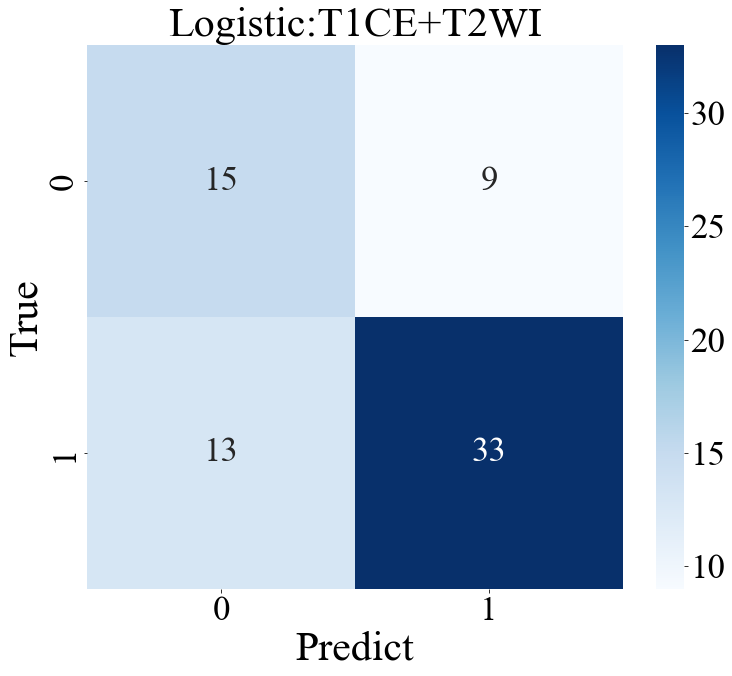

In [986]:
model= joblib.load(os.path.join(modeldir, DSM3_model)) 
y_pred = model.predict(DSM3_test_x)#, probability=True) #预测的标签
y_score = model.predict_proba(DSM3_test_x)#得到标签0 (y_predict[:,0])和1 (y_predict[:,1])对应的概率
y_true = DSM3_test_y  #真实标签
confusion_matrix_plot(y_true, y_pred,'./IMG/Logistic_DSM3_confusion.png', 'Logistic:T1CE+T2WI')
print(f'sensitivity, sepcificity and accuracy are {calcu_evaluation(y_true, y_pred)}, respectively')

## DSM+Clinical

### KNN

#### Internal test with DSM

In [1497]:
DSM3_KNN = joblib.load(os.path.join(modeldir, 'KNN_DSM3.model')) 
# DSM3_KNN_pred = DSM3_KNN.predict(DSM3_test_x)
DSM3_KNN_score = DSM3_KNN.predict_proba(DSM3_train_x)
DSM3_KNN_score1 = DSM3_KNN.predict_proba(DSM3_test_x)
DSM3_KNN_true = DSM3_test_y  #真实标签

Clinical_KNN = joblib.load(os.path.join(modeldir, 'KNN_Clinical.model')) 
Clinical_KNN_score = Clinical_KNN.predict_proba(Clinical_train_x)
Clinical_KNN_score1 = Clinical_KNN.predict_proba(Clinical_test_x)
Clinical_KNN_true = Clinical_test_y  #真实标签

CDSM_train_x = np.array([DSM3_KNN_score[:,1], Clinical_KNN_score[:, 1]]).T
CDSM_train_y = Clinical_train_y
CDSM_test_x = np.array([DSM3_KNN_score1[:,1], Clinical_KNN_score1[:, 1]]).T
CDSM_test_y = Clinical_test_y
CDSM_model = 'KNN_CDSM.model'
print(Clinical_train_x.shape)
print(CDSM_train_x.shape)

print(DSM3_KNN_score[:,1].shape)
CliRadio_train_x = np.concatenate((Clinical_train_x, DSM3_KNN_score[:,1:]), axis=1)
CliRadio_train_y = Clinical_train_y
CliRadio_test_x = np.concatenate((Clinical_test_x, DSM3_KNN_score1[:,1:]), axis=1)
CliRadio_test_y = Clinical_test_y
CliRadio_test_x.shape

(158, 10)
(158, 2)
(158,)


(70, 11)

#### Two scores model

In [1498]:
# Search optimal hyperparameter
random_regression_seed=np.random.randint(low=1,high=230)

C_range = [0.001, 0.01, 0.1, 1.0, 10, 100, 1000] # default=1.0
max_iter_range = [200, 300, 400] # default=100
class_weight_range = ['balanced', None] # default=None
solver_range = ['liblinear','sag','lbfgs','newton-cg']
penalty_range = ['l2']

hparam={'penalty':penalty_range,
                        'C':C_range,
                        'max_iter':max_iter_range,
                        'class_weight':class_weight_range,
                        'solver':solver_range
                        }
# Random search
model_test_base=LogisticRegression()
model_test_random=GridSearchCV(estimator=model_test_base,
                               param_grid=hparam,
                               n_jobs=-1,
                               cv=5,
                               verbose=1,
                               scoring='neg_log_loss'
                              )
model_test_random.fit(CDSM_train_x, CDSM_train_y)

best_CDSM = model_test_random.best_params_
pprint(best_CDSM)

Fitting 5 folds for each of 168 candidates, totalling 840 fits


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10, 100, 1000],
                         'class_weight': ['balanced', None],
                         'max_iter': [200, 300, 400], 'penalty': ['l2'],
                         'solver': ['liblinear', 'sag', 'lbfgs', 'newton-cg']},
             scoring='neg_log_loss', verbose=1)

{'C': 1000,
 'class_weight': 'balanced',
 'max_iter': 300,
 'penalty': 'l2',
 'solver': 'sag'}


In [1499]:
# Build RF regression model with optimal hyperparameters
logistic_CDSM=model_test_random.best_estimator_
# Predict test set data
score = logistic_CDSM.score(CDSM_test_x, CDSM_test_y)
print(score)
joblib.dump(logistic_CDSM, os.path.join(modeldir, CDSM_model))

0.8285714285714286


['/media/tx-deepocean/Data/2022/chongfu1/Model/Train/Model/KNN_CDSM.model']

In [1015]:
model= joblib.load(os.path.join(modeldir, 'KNN_CDSM.model')) 
predict_label = model.predict(CDSM_test_x)#, probability=True) #预测的标签
predict_score = model.predict_proba(CDSM_test_x)#得到标签0 (y_predict[:,0])和1 (y_predict[:,1])对应的概率
label = CDSM_test_y  #真实标签
eva_dic = classification_evaluation(label, predict_label, predict_score[:,1])
eva_dic

{'accuracy': 0.8142857142857143,
 'recall': 0.8913043478260869,
 'precision': 0.8367346938775511,
 'f1': 0.8631578947368421,
 'auc': 0.8795289855072463,
 'specificity': 0.6666666666666666}

#### External test with DSM

In [1016]:
DSM3_LogisticRegression = joblib.load(os.path.join(modeldir, 'KNN_DSM3.model')) 
# DSM3_LogisticRegression_pred = DSM3_LogisticRegression.predict(DSM3_test_x)
DSM3_LogisticRegression_score2 = DSM3_LogisticRegression.predict_proba(DSM3_extest_x)
DSM3_LogisticRegression_true = DSM3_extest_y  #真实标签

Clinical_LogisticRegression = joblib.load(os.path.join(modeldir, 'KNN_Clinical.model')) 
Clinical_LogisticRegression_score2 = Clinical_LogisticRegression.predict_proba(Clinical_extest_x)
Clinical_LogisticRegression_true = Clinical_extest_y  #真实标签

CDSM_extest_x = np.array([DSM3_LogisticRegression_score2[:,1], Clinical_LogisticRegression_score2[:, 1]]).T
CDSM_extest_y = Clinical_extest_y

In [1017]:
model= joblib.load(os.path.join(modeldir, 'KNN_CDSM.model')) 
predict_label = model.predict(CDSM_extest_x)#, probability=True) #预测的标签
predict_score = model.predict_proba(CDSM_extest_x)#得到标签0 (y_predict[:,0])和1 (y_predict[:,1])对应的概率
label = CDSM_extest_y  #真实标签
eva_dic = classification_evaluation(label, predict_label, predict_score[:,1])
eva_dic
print(len(predict_label))

{'accuracy': 0.7333333333333333,
 'recall': 0.8846153846153846,
 'precision': 0.71875,
 'f1': 0.7931034482758621,
 'auc': 0.7874493927125505,
 'specificity': 0.5263157894736842}

45


#### radiomics-score + clinical

In [1026]:
# Search optimal hyperparameter
from sklearn.neighbors import KNeighborsClassifier
random_regression_seed=np.random.randint(low=1,high=230)

hparam = [
    {
        'weights': ['uniform'],
        'n_neighbors': [i for i in range(1, 11)]
    },
    {
        'weights': ['distance'],
        'n_neighbors': [i for i in range(1, 11)],
        'p': [i for i in range(1, 6)]
    }
]

# Random search
model_base = KNeighborsClassifier()
model_grid = GridSearchCV(estimator=model_base,
                          param_grid=hparam,
                          n_jobs=-1,
                          cv=5,
                          verbose=1,
                          scoring='accuracy'
)
model_grid.fit(CliRadio_train_x, CliRadio_train_y)

best_Clinical = model_grid.best_params_
pprint(best_Clinical)

# Build RF regression model with optimal hyperparameters
CliRadio_KNN=model_grid.best_estimator_
# Predict test set data
score = CliRadio_KNN.score(CliRadio_test_x, CliRadio_test_y)
print(score)
joblib.dump(CliRadio_KNN, os.path.join(modeldir, 'KNN_CR.model'))

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid=[{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                          'weights': ['uniform']},
                         {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                          'p': [1, 2, 3, 4, 5], 'weights': ['distance']}],
             scoring='accuracy', verbose=1)

{'n_neighbors': 8, 'p': 4, 'weights': 'distance'}
0.8285714285714286


['/media/tx-deepocean/Data/2022/chongfu1/Model/Train/Model/KNN_CR.model']

In [1027]:
model= joblib.load(os.path.join(modeldir, 'KNN_CR.model')) 
predict_label = model.predict(CliRadio_test_x) #预测的标签
predict_score = model.predict_proba(CliRadio_test_x)#得到标签0 (y_predict[:,0])和1 (y_predict[:,1])对应的概率
label = CliRadio_test_y#真实标签
eva_dic = classification_evaluation(label, predict_label, predict_score[:,1])
eva_dic

{'accuracy': 0.8285714285714286,
 'recall': 0.8913043478260869,
 'precision': 0.8541666666666666,
 'f1': 0.8723404255319149,
 'auc': 0.9021739130434783,
 'specificity': 0.7083333333333334}

#### External test with DSM

In [1028]:
DSM3_KNN_model = joblib.load(os.path.join(modeldir, 'KNN_DSM3.model')) 
DSM3_KNN_score_ex = DSM3_KNN_model.predict_proba(DSM3_extest_x)
DSM3_KNN_true = DSM3_extest_y  #真实标签

Clinical_KNN = joblib.load(os.path.join(modeldir, 'KNN_Clinical.model')) 
Clinical_KNN_score_ex = Clinical_KNN.predict_proba(Clinical_extest_x)
Clinical_KNN_true = Clinical_extest_y  #真实标签

CDSM_extest_x = np.array([DSM3_KNN_score_ex[:,1], Clinical_KNN_score_ex[:, 1]]).T
CDSM_extest_y = Clinical_extest_y

print(DSM3_KNN_score[:,1].shape)
CliRadio_extest_x = np.concatenate((Clinical_extest_x, DSM3_KNN_score_ex[:,1:]), axis=1)
CliRadio_extest_y = Clinical_extest_y
CliRadio_extest_x.shape

(158,)


(45, 11)

In [1029]:
model= joblib.load(os.path.join(modeldir, 'KNN_CR.model')) 
predict_label = model.predict(CliRadio_extest_x)#, probability=True) #预测的标签
predict_score = model.predict_proba(CliRadio_extest_x)#得到标签0 (y_predict[:,0])和1 (y_predict[:,1])对应的概率
label = CliRadio_extest_y  #真实标签
eva_dic = classification_evaluation(label, predict_label, predict_score[:,1])
eva_dic
print(len(predict_label))

{'accuracy': 0.7111111111111111,
 'recall': 0.8076923076923077,
 'precision': 0.7241379310344828,
 'f1': 0.7636363636363636,
 'auc': 0.7580971659919029,
 'specificity': 0.5789473684210527}

45


### SVM

#### Internal test with DSM

In [439]:
DSM3_SVM = joblib.load(os.path.join(modeldir, 'RandomForest_DSM3.model')) 
# DSM3_SVM_pred = DSM3_SVM.predict(DSM3_test_x)
DSM3_SVM_score = DSM3_SVM.predict_proba(DSM3_train_x)
DSM3_SVM_score1 = DSM3_SVM.predict_proba(DSM3_test_x)
DSM3_SVM_true = DSM3_test_y  #真实标签

Clinical_SVM = joblib.load(os.path.join(modeldir, 'SVM_Clinical.model')) 
Clinical_SVM_score = Clinical_SVM.predict_proba(Clinical_train_x)
Clinical_SVM_score1 = Clinical_SVM.predict_proba(Clinical_test_x)
Clinical_SVM_true = Clinical_test_y  #真实标签

CDSM_train_x = np.array([DSM3_SVM_score[:,1], Clinical_SVM_score[:, 1]]).T
CDSM_train_y = Clinical_train_y
CDSM_test_x = np.array([DSM3_SVM_score1[:,1], Clinical_SVM_score1[:, 1]]).T
CDSM_test_y = Clinical_test_y
CDSM_model = 'SVM_CDSM.model'
print(Clinical_train_x.shape)
print(CDSM_train_x.shape)

(158, 10)
(158, 2)


In [440]:
# Search optimal hyperparameter
random_regression_seed=np.random.randint(low=1,high=230)

C_range = [0.001, 0.01, 0.1, 1.0, 10, 100, 1000] # default=1.0
max_iter_range = [200, 300, 400] # default=100
class_weight_range = ['balanced', None] # default=None
solver_range = ['liblinear','sag','lbfgs','newton-cg']
penalty_range = ['l2']

hparam={'penalty':penalty_range,
                        'C':C_range,
                        'max_iter':max_iter_range,
                        'class_weight':class_weight_range,
                        'solver':solver_range
                        }
# Random search
model_test_base=LogisticRegression()
model_test_random=GridSearchCV(estimator=model_test_base,
                               param_grid=hparam,
                               n_jobs=-1,
                               cv=5,
                               verbose=1,
                               scoring='accuracy'
                              )
model_test_random.fit(CDSM_train_x, CDSM_train_y)

best_CDSM = model_test_random.best_params_
pprint(best_CDSM)

Fitting 5 folds for each of 168 candidates, totalling 840 fits


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10, 100, 1000],
                         'class_weight': ['balanced', None],
                         'max_iter': [200, 300, 400], 'penalty': ['l2'],
                         'solver': ['liblinear', 'sag', 'lbfgs', 'newton-cg']},
             scoring='accuracy', verbose=1)

{'C': 1.0,
 'class_weight': 'balanced',
 'max_iter': 200,
 'penalty': 'l2',
 'solver': 'sag'}


In [441]:
# Build RF regression model with optimal hyperparameters
logistic_CDSM=model_test_random.best_estimator_
# Predict test set data
score = logistic_CDSM.score(CDSM_test_x, CDSM_test_y)
print(score)
joblib.dump(logistic_CDSM, os.path.join(modeldir, CDSM_model))

0.8714285714285714


['/media/tx-deepocean/Data/2022/chongfu1/Model/Train/Model/SVM_CDSM.model']

In [442]:
model= joblib.load(os.path.join(modeldir, 'SVM_CDSM.model')) 
predict_label = model.predict(CDSM_test_x)#, probability=True) #预测的标签
predict_score = model.predict_proba(CDSM_test_x)#得到标签0 (y_predict[:,0])和1 (y_predict[:,1])对应的概率
label = CDSM_test_y  #真实标签
eva_dic = classification_evaluation(label, predict_label, predict_score[:,1])
eva_dic

{'accuracy': 0.8714285714285714,
 'recall': 0.8695652173913043,
 'precision': 0.9302325581395349,
 'f1': 0.898876404494382,
 'auc': 0.9248188405797101,
 'specificity': 0.875}

sensitivity, sepcificity and accuracy are (0.8695652173913043, 0.875, 0.8714285714285714), respectively


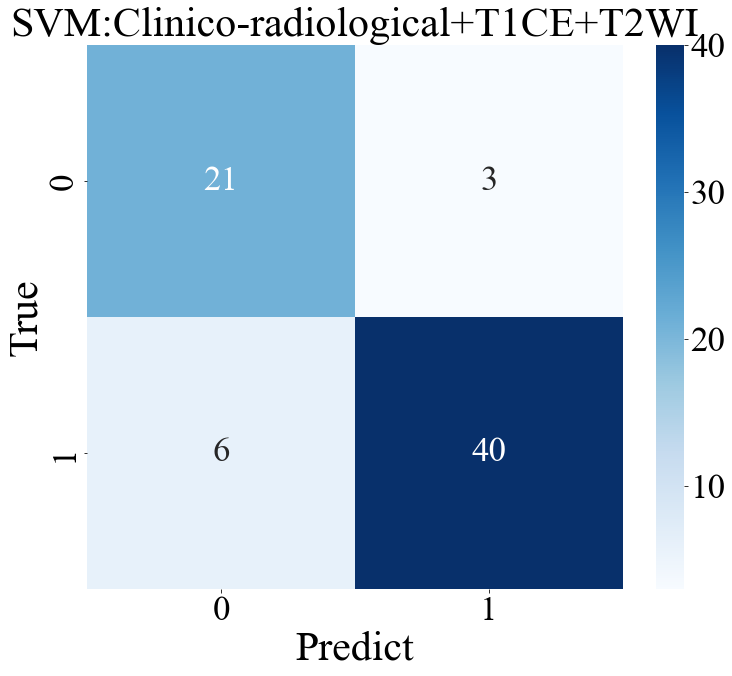

In [443]:
confusion_matrix_plot(label, predict_label,'./IMG/SVM_CDSM_confusion.png', 'SVM:Clinico-radiological+T1CE+T2WI')
print(f'sensitivity, sepcificity and accuracy are {calcu_evaluation(label, predict_label)}, respectively')

#### External test with DSM

In [444]:
DSM3_LogisticRegression = joblib.load(os.path.join(modeldir, 'RandomForest_DSM3.model')) 
# DSM3_LogisticRegression_pred = DSM3_LogisticRegression.predict(DSM3_test_x)
DSM3_LogisticRegression_score2 = DSM3_LogisticRegression.predict_proba(DSM3_extest_x)
DSM3_LogisticRegression_true = DSM3_extest_y  #真实标签

Clinical_LogisticRegression = joblib.load(os.path.join(modeldir, 'SVM_Clinical.model')) 
Clinical_LogisticRegression_score2 = Clinical_LogisticRegression.predict_proba(Clinical_extest_x)
Clinical_LogisticRegression_true = Clinical_extest_y  #真实标签

CDSM_extest_x = np.array([DSM3_LogisticRegression_score2[:,1], Clinical_LogisticRegression_score2[:, 1]]).T
CDSM_extest_y = Clinical_extest_y

In [445]:
model= joblib.load(os.path.join(modeldir, 'SVM_CDSM.model')) 
predict_label = model.predict(CDSM_extest_x)#, probability=True) #预测的标签
predict_score = model.predict_proba(CDSM_extest_x)#得到标签0 (y_predict[:,0])和1 (y_predict[:,1])对应的概率
label = CDSM_extest_y  #真实标签
eva_dic = classification_evaluation(label, predict_label, predict_score[:,1])
eva_dic

{'accuracy': 0.5777777777777777,
 'recall': 1.0,
 'precision': 0.5777777777777777,
 'f1': 0.732394366197183,
 'auc': 0.5668016194331984,
 'specificity': 0.0}

sensitivity, sepcificity and accuracy are (0.8461538461538461, 0.5789473684210527, 0.7333333333333333), respectively


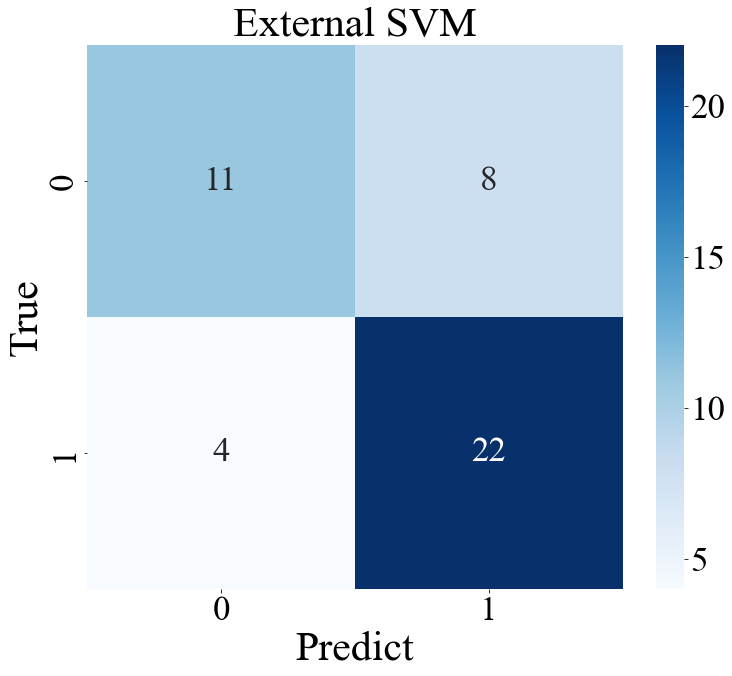

In [1037]:
confusion_matrix_plot(label, predict_label,'./IMG/SVM_exCDSM_confusion.png', 'External SVM')
print(f'sensitivity, sepcificity and accuracy are {calcu_evaluation(label, predict_label)}, respectively')

#### NaiveBayes

In [921]:
SSM4_NaiveBayes = joblib.load(os.path.join(modeldir, 'NaiveBayes_SSM4.model')) 
# SSM4_NaiveBayes_pred = SSM4_NaiveBayes.predict(SSM4_test_x)
SSM4_NaiveBayes_score = SSM4_NaiveBayes.predict_proba(SSM4_train_x)
SSM4_NaiveBayes_score1 = SSM4_NaiveBayes.predict_proba(SSM4_test_x)
SSM4_NaiveBayes_true = SSM4_test_y  #真实标签

Clinical_NaiveBayes = joblib.load(os.path.join(modeldir, 'NaiveBayes_Clinical.model')) 
Clinical_NaiveBayes_score = Clinical_NaiveBayes.predict_proba(Clinical_train_x)
Clinical_NaiveBayes_score1 = Clinical_NaiveBayes.predict_proba(Clinical_test_x)
Clinical_NaiveBayes_true = Clinical_test_y  #真实标签

CDSM_train_x = np.array([SSM4_NaiveBayes_score[:,1], Clinical_NaiveBayes_score[:, 1]]).T
CDSM_train_y = Clinical_train_y
CDSM_test_x = np.array([SSM4_NaiveBayes_score1[:,1], Clinical_NaiveBayes_score1[:, 1]]).T
CDSM_test_y = Clinical_test_y
CDSM_model = 'NaiveBayes_CDSM.model'
print(Clinical_train_x.shape)
print(CDSM_train_x.shape)

(158, 10)
(158, 2)


In [922]:
# Search optimal hyperparameter
random_regression_seed=np.random.randint(low=1,high=230)

C_range = [0.001, 0.01, 0.1, 1.0, 10, 100, 1000] # default=1.0
max_iter_range = [200, 300, 400] # default=100
class_weight_range = ['balanced', None] # default=None
solver_range = ['liblinear','sag','lbfgs','newton-cg']
penalty_range = ['l2']

hparam={'penalty':penalty_range,
                        'C':C_range,
                        'max_iter':max_iter_range,
                        'class_weight':class_weight_range,
                        'solver':solver_range
                        }
# Random search
model_test_base=LogisticRegression()
model_test_random=GridSearchCV(estimator=model_test_base,
                               param_grid=hparam,
                               n_jobs=-1,
                               cv=5,
                               verbose=1,
                               scoring='accuracy'
                              )
model_test_random.fit(CDSM_train_x, CDSM_train_y)

best_CDSM = model_test_random.best_params_
pprint(best_CDSM)

Fitting 5 folds for each of 168 candidates, totalling 840 fits


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10, 100, 1000],
                         'class_weight': ['balanced', None],
                         'max_iter': [200, 300, 400], 'penalty': ['l2'],
                         'solver': ['liblinear', 'sag', 'lbfgs', 'newton-cg']},
             scoring='accuracy', verbose=1)

{'C': 0.001,
 'class_weight': None,
 'max_iter': 200,
 'penalty': 'l2',
 'solver': 'liblinear'}


In [923]:
# Build RF regression model with optimal hyperparameters
logistic_CDSM=model_test_random.best_estimator_
# Predict test set data
score = logistic_CDSM.score(CDSM_test_x, CDSM_test_y)
print(score)
joblib.dump(logistic_CDSM, os.path.join(modeldir, CDSM_model))

0.6571428571428571


['/media/tx-deepocean/Data/2022/chongfu1/Model/Train/Model/NaiveBayes_CDSM.model']

In [924]:
model= joblib.load(os.path.join(modeldir, CDSM_model)) 
predict_label = model.predict(CDSM_test_x)#, probability=True) #预测的标签
predict_score = model.predict_proba(CDSM_test_x)#得到标签0 (y_predict[:,0])和1 (y_predict[:,1])对应的概率
label = CDSM_test_y  #真实标签
eva_dic = classification_evaluation(label, predict_label, predict_score[:,1])
eva_dic

{'accuracy': 0.6571428571428571,
 'recall': 1.0,
 'precision': 0.6571428571428571,
 'f1': 0.7931034482758621,
 'auc': 0.4411231884057971,
 'specificity': 0.0}

### Logistic Regression

#### Internal test with DSM

In [1056]:
# Load the Clinical features.
Atag_cols = ['pid', 'label']
Clinical_train = pd.read_csv(os.path.join(traindir, 'clinical_lasso_sel.csv')) 
Clinical_test = pd.read_csv(os.path.join(testdir, 'clinical_test.csv')) 
# Train data
standardscaler = StandardScaler()
Clinical_train = Clinical_train.sample(frac=1.0, random_state=random_state) 
Clinical_train_y = Clinical_train['label'] 
Clinical_train_x = Clinical_train.drop(Atag_cols, axis=1) 
# Test data
Clinical_test_y = Clinical_test['label']
Clinical_test_x = Clinical_test.drop(Atag_cols, axis=1)
print(Clinical_test_x.shape)
Clinical_train.head()
Clinical_test.head()

(70, 10)


,pid,label,mass_feature,NLR,diaphram_nodule,CA125,parenchymal_organs,HE4,ascites_amount,relationship_on_T1_dual_echo_images,peritoneum_mesentery_nodules,LDH
7,11,1,3,3.676161,0,0.058255,0,-0.014477,2,3,1,-0.522290
18,26,0,2,0.073904,0,-0.554732,0,-0.551002,2,2,1,-0.449370
152,228,0,2,-0.147421,0,-0.548614,0,-0.140826,1,1,1,0.069174
1,2,1,2,0.436419,0,-0.520656,0,-0.399017,1,3,1,-0.315683
75,112,0,1,0.058640,0,-0.467112,0,-0.381621,2,0,0,-0.643824


,pid,label,mass_feature,NLR,diaphram_nodule,CA125,parenchymal_organs,HE4,ascites_amount,relationship_on_T1_dual_echo_images,peritoneum_mesentery_nodules,LDH
0,5,1,2,1.317512,0,-0.080240,0,-0.653564,2,0,1,0.053828
1,6,1,2,1.384848,0,-0.063505,0,-0.361334,2,2,1,1.492248
2,7,1,3,-0.166941,0,-0.229288,0,0.324561,2,3,1,4.500577
3,17,1,3,-0.368949,0,-0.284774,0,-0.682545,2,2,1,-0.364549
4,19,1,2,1.565431,1,-0.050291,0,0.562451,2,3,1,1.336851


In [1057]:
#DSM3_LogisticRegression = joblib.load(os.path.join(modeldir, 'LogisticRegression_DSM3.model')) 
DSM3_LogisticRegression = joblib.load(os.path.join(modeldir, 'RandomForest_DSM3.model')) 
# DSM3_LogisticRegression_pred = DSM3_LogisticRegression.predict(DSM3_test_x)
DSM3_LogisticRegression_score = DSM3_LogisticRegression.predict_proba(DSM3_train_x)
DSM3_LogisticRegression_score1 = DSM3_LogisticRegression.predict_proba(DSM3_test_x)
DSM3_LogisticRegression_true = DSM3_test_y  #真实标签

Clinical_LogisticRegression = joblib.load(os.path.join(modeldir, 'LogisticRegression_clinical.model')) 
Clinical_LogisticRegression_score = Clinical_LogisticRegression.predict_proba(Clinical_train_x)
Clinical_LogisticRegression_score1 = Clinical_LogisticRegression.predict_proba(Clinical_test_x)
Clinical_LogisticRegression_true = Clinical_test_y  #真实标签

CDSM_train_x = np.array([DSM3_LogisticRegression_score[:,1], Clinical_LogisticRegression_score[:, 1]]).T
CDSM_train_y = Clinical_train_y
CDSM_test_x = np.array([DSM3_LogisticRegression_score1[:,1], Clinical_LogisticRegression_score1[:, 1]]).T
CDSM_test_y = Clinical_test_y
CDSM_model = 'LogisticRegression_CDSM.model'
print(Clinical_train_x.shape)
print(CDSM_train_x.shape)

Clinical_train_x
CliRadio_train_x = Clinical_train_x.copy()
CliRadio_train_x['Radiomics_score'] = np.array(DSM3_LogisticRegression_score[:,1])
CliRadio_train_y = Clinical_train_y
CliRadio_test_x = Clinical_test_x.copy()
CliRadio_test_x['Radiomics_score'] = np.array(DSM3_LogisticRegression_score1[:,1])
#CliRadio_test_x = np.concatenate((Clinical_test_x, DSM3_LogisticRegression_score1[:,1:]), axis=1)
CliRadio_test_y = Clinical_test_y
CliRadio_test_x.shape
CliRadio_train_x

(158, 10)
(158, 2)


,mass_feature,NLR,diaphram_nodule,CA125,parenchymal_organs,HE4,ascites_amount,relationship_on_T1_dual_echo_images,peritoneum_mesentery_nodules,LDH
7,3,3.676161,0,0.058255,0,-0.014477,2,3,1,-0.522290
18,2,0.073904,0,-0.554732,0,-0.551002,2,2,1,-0.449370
152,2,-0.147421,0,-0.548614,0,-0.140826,1,1,1,0.069174
1,2,0.436419,0,-0.520656,0,-0.399017,1,3,1,-0.315683
75,1,0.058640,0,-0.467112,0,-0.381621,2,0,0,-0.643824
...,...,...,...,...,...,...,...,...,...,...
101,3,0.589057,0,1.418104,0,-0.083145,2,2,1,-0.445319
120,3,-0.387826,0,-0.607398,0,-0.529944,1,2,1,-0.595211
130,1,-0.674022,0,-0.574288,0,-0.477756,2,2,1,-0.591159
143,2,0.157855,1,0.916947,0,0.125605,1,3,1,-0.214405


(70, 11)

,mass_feature,NLR,diaphram_nodule,CA125,parenchymal_organs,HE4,ascites_amount,relationship_on_T1_dual_echo_images,peritoneum_mesentery_nodules,LDH,Radiomics_score
7,3,3.676161,0,0.058255,0,-0.014477,2,3,1,-0.522290,0.779107
18,2,0.073904,0,-0.554732,0,-0.551002,2,2,1,-0.449370,0.624912
152,2,-0.147421,0,-0.548614,0,-0.140826,1,1,1,0.069174,0.420327
1,2,0.436419,0,-0.520656,0,-0.399017,1,3,1,-0.315683,0.663870
75,1,0.058640,0,-0.467112,0,-0.381621,2,0,0,-0.643824,0.192862
...,...,...,...,...,...,...,...,...,...,...,...
101,3,0.589057,0,1.418104,0,-0.083145,2,2,1,-0.445319,0.655678
120,3,-0.387826,0,-0.607398,0,-0.529944,1,2,1,-0.595211,0.504282
130,1,-0.674022,0,-0.574288,0,-0.477756,2,2,1,-0.591159,0.259739
143,2,0.157855,1,0.916947,0,0.125605,1,3,1,-0.214405,0.621129


In [1058]:
# Search optimal hyperparameter
random_regression_seed=np.random.randint(low=1,high=230)



C_range = [0.001, 0.02, 0.01, 0.1, 1.0, 10, 20,100, 1000] # default=1.0
max_iter_range = [1000,1500] # default=100
class_weight_range = ['balanced', None] # default=None
solver_range = ['liblinear','sag','lbfgs','newton-cg']
tol_range = [1e-5, 1e-4, 1e-3]
class_weight_range = ['balanced', None] # default=None
solver_range = ['liblinear','sag','saga','lbfgs','newton-cg']
penalty_range = ['l2', 'l1']
multi_range = ['auto', 'ovr', 'multinomial']

hparam={'penalty':penalty_range,
                        'C':C_range,
                        'max_iter':max_iter_range,
                        'class_weight':class_weight_range,
                        'solver':solver_range,
                        'multi_class':multi_range,
                        'tol':tol_range,
                        # 'bootstrap':bootstrap_range
                        }
# Random search
model_test_base=LogisticRegression()
model_test_random=GridSearchCV(estimator=model_test_base,
                               param_grid=hparam,
                               n_jobs=-1,
                               cv=6,
                               verbose=1,
                               scoring='balanced_accuracy'
                              )
model_test_random.fit(CDSM_train_x, CDSM_train_y)

best_CDSM = model_test_random.best_params_
pprint(best_CDSM)

Fitting 6 folds for each of 3240 candidates, totalling 19440 fits


GridSearchCV(cv=6, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.001, 0.02, 0.01, 0.1, 1.0, 10, 20, 100, 1000],
                         'class_weight': ['balanced', None],
                         'max_iter': [1000, 1500],
                         'multi_class': ['auto', 'ovr', 'multinomial'],
                         'penalty': ['l2', 'l1'],
                         'solver': ['liblinear', 'sag', 'saga', 'lbfgs',
                                    'newton-cg'],
                         'tol': [1e-05, 0.0001, 0.001]},
             scoring='balanced_accuracy', verbose=1)

{'C': 1.0,
 'class_weight': 'balanced',
 'max_iter': 1000,
 'multi_class': 'auto',
 'penalty': 'l1',
 'solver': 'saga',
 'tol': 1e-05}


In [1059]:
# Build RF regression model with optimal hyperparameters
logistic_CDSM=model_test_random.best_estimator_
# Predict test set data
score = logistic_CDSM.score(CDSM_test_x, CDSM_test_y)
print(score)
joblib.dump(logistic_CDSM, os.path.join(modeldir, CDSM_model))

0.8285714285714286


['/media/tx-deepocean/Data/2022/chongfu1/Model/Train/Model/LogisticRegression_CDSM.model']

In [1060]:
model= joblib.load(os.path.join(modeldir, 'LogisticRegression_CDSM.model')) 
predict_label = model.predict(CDSM_test_x)#, probability=True) #预测的标签
predict_score = model.predict_proba(CDSM_test_x)#得到标签0 (y_predict[:,0])和1 (y_predict[:,1])对应的概率
label = CDSM_test_y  #真实标签
eva_dic = classification_evaluation(label, predict_label, predict_score[:,1])
eva_dic

{'accuracy': 0.8285714285714286,
 'recall': 0.9130434782608695,
 'precision': 0.84,
 'f1': 0.8749999999999999,
 'auc': 0.9166666666666666,
 'specificity': 0.6666666666666666}

sensitivity, sepcificity and accuracy are (0.9130434782608695, 0.6666666666666666, 0.8285714285714286), respectively


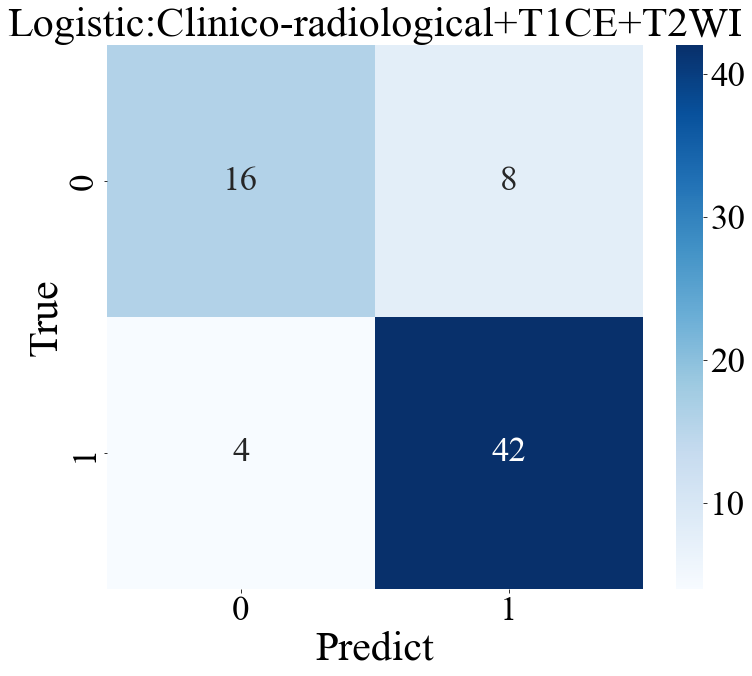

In [1061]:
confusion_matrix_plot(label, predict_label,'./IMG/Logistic_CDSM_confusion.png', 'Logistic:Clinico-radiological+T1CE+T2WI')
print(f'sensitivity, sepcificity and accuracy are {calcu_evaluation(label, predict_label)}, respectively')

#### External test with DSM

In [1062]:
DSM3_LogisticRegression = joblib.load(os.path.join(modeldir, 'RandomForest_DSM3.model')) 
# DSM3_LogisticRegression_pred = DSM3_LogisticRegression.predict(DSM3_test_x)
DSM3_LogisticRegression_score2 = DSM3_LogisticRegression.predict_proba(DSM3_extest_x)
DSM3_LogisticRegression_true = DSM3_extest_y  #真实标签

Clinical_LogisticRegression = joblib.load(os.path.join(modeldir, 'LogisticRegression_clinical.model')) 
Clinical_LogisticRegression_score2 = Clinical_LogisticRegression.predict_proba(Clinical_extest_x)
Clinical_LogisticRegression_true = Clinical_extest_y  #真实标签

CDSM_extest_x = np.array([DSM3_LogisticRegression_score2[:,1], Clinical_LogisticRegression_score2[:, 1]]).T
CDSM_extest_y = Clinical_extest_y

In [1063]:
model= joblib.load(os.path.join(modeldir, CDSM_model)) 
predict_label = model.predict(CDSM_extest_x)#, probability=True) #预测的标签
predict_score = model.predict_proba(CDSM_extest_x)#得到标签0 (y_predict[:,0])和1 (y_predict[:,1])对应的概率
label = CDSM_extest_y  #真实标签
print(len(label))
eva_dic = classification_evaluation(label, predict_label, predict_score[:,1])
eva_dic

45


{'accuracy': 0.7333333333333333,
 'recall': 0.7692307692307693,
 'precision': 0.7692307692307693,
 'f1': 0.7692307692307693,
 'auc': 0.7955465587044535,
 'specificity': 0.6842105263157895}

sensitivity, sepcificity and accuracy are (0.7692307692307693, 0.6842105263157895, 0.7333333333333333), respectively


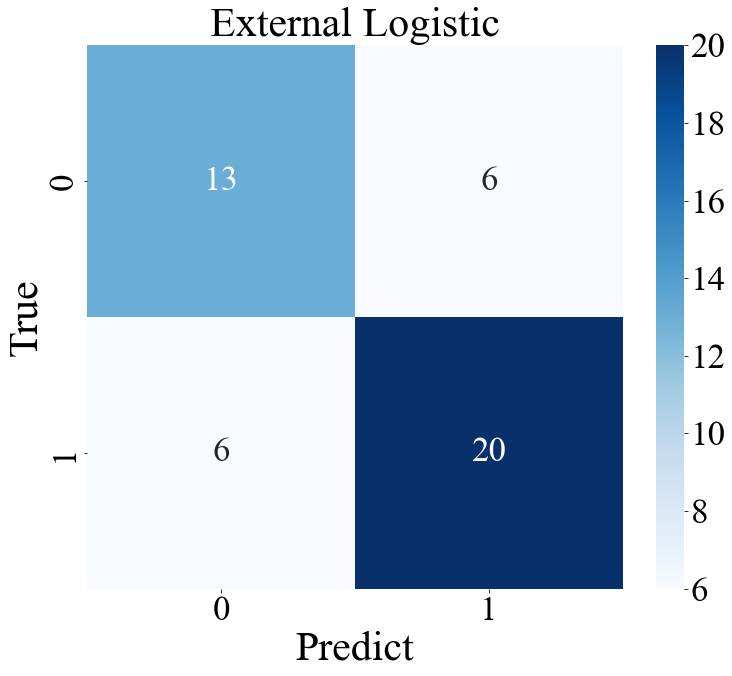

In [1064]:
confusion_matrix_plot(label, predict_label,'./IMG/Logistic_exCDSM_confusion.png', 'External Logistic')
print(f'sensitivity, sepcificity and accuracy are {calcu_evaluation(label, predict_label)}, respectively')

#### radiomics-score + clinical

In [1416]:
# 过采样
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import ADASYN 
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import ClusterCentroids 
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import AllKNN
from imblearn.combine import SMOTETomek, SMOTEENN
train_X, train_Y = CliRadio_train_x, CliRadio_train_y

smote = SMOTE(k_neighbors=4, random_state=42)
X_smote, Y_smote = smote.fit_resample(train_X, train_Y)

bsmote = BorderlineSMOTE(k_neighbors=3, random_state=42)
X_smote, Y_smote = bsmote.fit_resample(train_X, train_Y)

adasyn = ADASYN(n_neighbors=3, random_state=42)
#X_smote, Y_smote = adasyn.fit_resample(train_X, train_Y)

tl = TomekLinks()
X_smote, Y_smote = tl.fit_resample(train_X, train_Y)
X_smote, Y_smote = smote.fit_resample(X_smote, Y_smote)
#X_smote, Y_smote = smote_tomek.fit_resample(X_smote, Y_smote)
X_smote, Y_smote = cc.fit_resample(X_smote, Y_smote)
#X_smote, Y_smote = tl.fit_resample(X_smote, Y_smote)

cc = ClusterCentroids(random_state=42)
#X_smote, Y_smote = cc.fit_resample(train_X, train_Y)

# 形参默认 version=1, 即采用 NearMiss-1; 若 version=2 用 NearMiss-2, version=3 用 NearMiss-3
nm_1 = NearMiss(version=3)
# 生成新数据集
#X_smote, Y_smote = nm_1.fit_resample(train_X, train_Y)

allknn = AllKNN()
#X_smote, Y_smote = allknn.fit_resample(train_X, train_Y)


# 实例化类对象
smote_enn = SMOTEENN(random_state=42)
smote_tomek = SMOTETomek(random_state=42)
# 生成新数据集
#X_smote, Y_smote = smote_enn.fit_resample(train_X, train_Y)
#X_smote, Y_smote = smote_tomek.fit_resample(train_X, train_Y)



CliRadio_train_x1 = X_smote
CliRadio_train_y1 = Y_smote
print(Y_smote.sum())
len(CliRadio_train_x1)
CliRadio_train_x1

94


188

,mass_feature,NLR,diaphram_nodule,CA125,parenchymal_organs,HE4,ascites_amount,relationship_on_T1_dual_echo_images,peritoneum_mesentery_nodules,LDH,Radiomics_score
0,2,0.073904,0,-0.554732,0,-0.551002,2,2,1,-0.449370,0.624912
1,2,-0.147421,0,-0.548614,0,-0.140826,1,1,1,0.069174,0.420327
2,1,0.058640,0,-0.467112,0,-0.381621,2,0,0,-0.643824,0.192862
3,3,-0.986930,0,-0.559650,0,-0.558326,1,0,0,-0.473677,0.654654
4,1,-0.414538,0,-0.556313,0,-0.551917,1,0,0,-0.599262,0.308513
...,...,...,...,...,...,...,...,...,...,...,...
183,1,-0.536648,0,-0.452241,0,-0.350492,1,2,1,-0.461523,0.266849
184,2,-0.418354,0,-0.282915,0,-0.375212,2,2,1,-0.096922,0.461508
185,3,-1.120489,0,-0.602948,0,-0.557411,1,2,0,-0.647875,0.648578
186,2,0.722615,0,-0.445449,0,-0.496983,1,3,1,-0.226558,0.666959


In [1443]:
# Search optimal hyperparameter
random_regression_seed=np.random.randint(low=1,high=230)



C_range = [0.001, 0.02, 0.05, 0.1, 0.3, 0.5,1.0, 2.0,5, 10, 100] # default=1.0
max_iter_range = [1000] # default=100
class_weight_range = ['balanced', None] # default=None
solver_range = ['liblinear','sag','lbfgs','newton-cg']
tol_range = [1e-6,1e-5, 1e-4, 1e-3]
class_weight_range = ['balanced', None] # default=None
solver_range = ['liblinear','sag','saga','lbfgs','newton-cg']
penalty_range = ['l2', 'l1']
multi_range = ['auto', 'ovr', 'multinomial']

hparam={'penalty':penalty_range,
                        'C':C_range,
                        'max_iter':max_iter_range,
                        'class_weight':class_weight_range,
                        'solver':solver_range,
                        'multi_class':multi_range,
                        'tol':tol_range,
                        # 'bootstrap':bootstrap_range
                        }
# Random search
model_test_base=LogisticRegression()
model_test_random=GridSearchCV(estimator=model_test_base,
                               param_grid=hparam,
                               n_jobs=-1,
                               cv=4,
                               verbose=1,
                               scoring='roc_auc_ovo'
                              )
model_test_random.fit(CliRadio_train_x1, CliRadio_train_y1)
#model_test_random.fit(CliRadio_train_x, CliRadio_train_y)

best_CDSM = model_test_random.best_params_
pprint(best_CDSM)

Fitting 4 folds for each of 2640 candidates, totalling 10560 fits


/media/tx-deepocean/Data/TX_wrapperenv/chongfu1/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/media/tx-deepocean/Data/TX_wrapperenv/chongfu1/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/media/tx-deepocean/Data/TX_wrapperenv/chongfu1/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/media/tx-deepocean/Data/TX_wrapperenv/chongfu1/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/media/tx-deepocean/Data/TX_wrapperenv/chongfu1/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The ma

GridSearchCV(cv=4, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.001, 0.02, 0.05, 0.1, 0.3, 0.5, 1.0, 2.0, 5,
                               10, 100],
                         'class_weight': ['balanced', None], 'max_iter': [1000],
                         'multi_class': ['auto', 'ovr', 'multinomial'],
                         'penalty': ['l2', 'l1'],
                         'solver': ['liblinear', 'sag', 'saga', 'lbfgs',
                                    'newton-cg'],
                         'tol': [1e-06, 1e-05, 0.0001, 0.001]},
             scoring='roc_auc_ovo', verbose=1)

{'C': 1.0,
 'class_weight': 'balanced',
 'max_iter': 1000,
 'multi_class': 'multinomial',
 'penalty': 'l1',
 'solver': 'saga',
 'tol': 0.001}


In [1444]:
CliRadio_LogisticRegression=model_test_random.best_estimator_
# Predict test set data
score = CliRadio_LogisticRegression.score(CliRadio_test_x, CliRadio_test_y)
print(score)
joblib.dump(CliRadio_LogisticRegression, os.path.join(modeldir, 'LogisticRegression_CR.model'))

0.9285714285714286


['/media/tx-deepocean/Data/2022/chongfu1/Model/Train/Model/LogisticRegression_CR.model']

In [1445]:
model= joblib.load(os.path.join(modeldir, 'LogisticRegression_CR.model')) 
predict_label = model.predict(CliRadio_test_x) #预测的标签
predict_score = model.predict_proba(CliRadio_test_x)#得到标签0 (y_predict[:,0])和1 (y_predict[:,1])对应的概率
label = CliRadio_test_y#真实标签
eva_dic = classification_evaluation(label, predict_label, predict_score[:,1])
eva_dic
CliRadio_test_x.head()

{'accuracy': 0.9285714285714286,
 'recall': 0.9130434782608695,
 'precision': 0.9767441860465116,
 'f1': 0.9438202247191011,
 'auc': 0.9420289855072465,
 'specificity': 0.9583333333333334}

,mass_feature,NLR,diaphram_nodule,CA125,parenchymal_organs,HE4,ascites_amount,relationship_on_T1_dual_echo_images,peritoneum_mesentery_nodules,LDH,Radiomics_score
0,2,1.317512,0,-0.080240,0,-0.653564,2,0,1,0.053828,0.561698
1,2,1.384848,0,-0.063505,0,-0.361334,2,2,1,1.492248,0.598037
2,3,-0.166941,0,-0.229288,0,0.324561,2,3,1,4.500577,0.594308
3,3,-0.368949,0,-0.284774,0,-0.682545,2,2,1,-0.364549,0.668554
4,2,1.565431,1,-0.050291,0,0.562451,2,3,1,1.336851,0.696076


#### External test with DSM

In [1446]:
DSM3_LogisticRegression_model = joblib.load(os.path.join(modeldir, 'RandomForest_DSM3.model')) 
DSM3_LogisticRegression_score_ex = DSM3_LogisticRegression_model.predict_proba(exDSM3_test_x)
DSM3_LogisticRegression_true = exDSM3_test_y  #真实标签

Clinical_LogisticRegression = joblib.load(os.path.join(modeldir, 'LogisticRegression_clinical.model')) 
Clinical_LogisticRegression_score_ex = Clinical_LogisticRegression.predict_proba(Clinical_extest_x)
Clinical_LogisticRegression_true = Clinical_extest_y  #真实标签

CDSM_extest_x = np.array([DSM3_LogisticRegression_score_ex[:,1], Clinical_LogisticRegression_score_ex[:, 1]]).T
CDSM_extest_y = Clinical_extest_y

print(DSM3_LogisticRegression_score[:,1].shape)
CliRadio_extest_x = Clinical_extest_x.copy()
CliRadio_extest_x['Radiomics_score'] = np.array(DSM3_LogisticRegression_score_ex[:,1])
CliRadio_extest_y = Clinical_extest_y

(158,)


In [1447]:
model= joblib.load(os.path.join(modeldir, 'LogisticRegression_CR.model')) 
predict_label = model.predict(CliRadio_extest_x)#, probability=True) #预测的标签
predict_score = model.predict_proba(CliRadio_extest_x)#得到标签0 (y_predict[:,0])和1 (y_predict[:,1])对应的概率
label = CliRadio_extest_y  #真实标签
eva_dic = classification_evaluation(label, predict_label, predict_score[:,1])
eva_dic
print(len(predict_label))

{'accuracy': 0.7555555555555555,
 'recall': 0.7692307692307693,
 'precision': 0.8,
 'f1': 0.7843137254901961,
 'auc': 0.8076923076923077,
 'specificity': 0.7368421052631579}

45


### RForest 

#### Internal test with DSM

In [1051]:
DSM3_LogisticRegression = joblib.load(os.path.join(modeldir, 'RandomForest_DSM3.model')) 
# DSM3_LogisticRegression_pred = DSM3_LogisticRegression.predict(DSM3_test_x)
DSM3_LogisticRegression_score = DSM3_LogisticRegression.predict_proba(DSM3_train_x)
DSM3_LogisticRegression_score1 = DSM3_LogisticRegression.predict_proba(DSM3_test_x)
DSM3_LogisticRegression_true = DSM3_test_y  #真实标签

Clinical_LogisticRegression = joblib.load(os.path.join(modeldir, 'RandomForest_Clinical.model')) 
Clinical_LogisticRegression_score = Clinical_LogisticRegression.predict_proba(Clinical_train_x)
Clinical_LogisticRegression_score1 = Clinical_LogisticRegression.predict_proba(Clinical_test_x)
Clinical_LogisticRegression_true = Clinical_test_y  #真实标签

CDSM_train_x = np.array([DSM3_LogisticRegression_score[:,1], Clinical_LogisticRegression_score[:, 1]]).T
CDSM_train_y = Clinical_train_y
CDSM_test_x = np.array([DSM3_LogisticRegression_score1[:,1], Clinical_LogisticRegression_score1[:, 1]]).T
CDSM_test_y = Clinical_test_y
CDSM_model = 'RandomForest_CDSM.model'
print(Clinical_train_x.shape)
print(CDSM_train_x.shape)

(158, 10)
(158, 2)


In [1052]:
# Search optimal hyperparameter
random_regression_seed=np.random.randint(low=1,high=230)

C_range = [0.001, 0.01, 0.1, 1.0, 10, 100, 1000] # default=1.0
max_iter_range = [200, 300, 400] # default=100
class_weight_range = ['balanced', None] # default=None
solver_range = ['liblinear','sag','lbfgs','newton-cg']
penalty_range = ['l2']

hparam={'penalty':penalty_range,
                        'C':C_range,
                        'max_iter':max_iter_range,
                        'class_weight':class_weight_range,
                        'solver':solver_range
                        }
# Random search
model_test_base=LogisticRegression()
model_test_random=GridSearchCV(estimator=model_test_base,
                               param_grid=hparam,
                               n_jobs=-1,
                               cv=5,
                               verbose=1,
                               scoring='balanced_accuracy'
                              )
model_test_random.fit(CDSM_train_x, CDSM_train_y)

best_CDSM = model_test_random.best_params_
pprint(best_CDSM)

Fitting 5 folds for each of 168 candidates, totalling 840 fits


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10, 100, 1000],
                         'class_weight': ['balanced', None],
                         'max_iter': [200, 300, 400], 'penalty': ['l2'],
                         'solver': ['liblinear', 'sag', 'lbfgs', 'newton-cg']},
             scoring='balanced_accuracy', verbose=1)

{'C': 10,
 'class_weight': None,
 'max_iter': 200,
 'penalty': 'l2',
 'solver': 'liblinear'}


In [1053]:
# Build RF regression model with optimal hyperparameters
logistic_CDSM=model_test_random.best_estimator_
# Predict test set data
score = logistic_CDSM.score(CDSM_test_x, CDSM_test_y)
print(score)
joblib.dump(logistic_CDSM, os.path.join(modeldir, CDSM_model))

0.7857142857142857


['/media/tx-deepocean/Data/2022/chongfu1/Model/Train/Model/RandomForest_CDSM.model']

In [1054]:
model= joblib.load(os.path.join(modeldir, 'RandomForest_CDSM.model')) 
predict_label = model.predict(CDSM_test_x)#, probability=True) #预测的标签
predict_score = model.predict_proba(CDSM_test_x)#得到标签0 (y_predict[:,0])和1 (y_predict[:,1])对应的概率
label = CDSM_test_y  #真实标签
eva_dic = classification_evaluation(label, predict_label, predict_score[:,1])
eva_dic

{'accuracy': 0.7857142857142857,
 'recall': 0.8478260869565217,
 'precision': 0.8297872340425532,
 'f1': 0.8387096774193549,
 'auc': 0.8677536231884059,
 'specificity': 0.6666666666666666}

#### External test with DSM

In [1055]:
DSM3_LogisticRegression = joblib.load(os.path.join(modeldir, 'RandomForest_DSM3.model')) 
# DSM3_LogisticRegression_pred = DSM3_LogisticRegression.predict(DSM3_test_x)
DSM3_LogisticRegression_score2 = DSM3_LogisticRegression.predict_proba(DSM3_extest_x)
DSM3_LogisticRegression_true = DSM3_extest_y  #真实标签

Clinical_LogisticRegression = joblib.load(os.path.join(modeldir, 'RandomForest_Clinical.model')) 
Clinical_LogisticRegression_score2 = Clinical_LogisticRegression.predict_proba(Clinical_extest_x)
Clinical_LogisticRegression_true = Clinical_extest_y  #真实标签

CDSM_extest_x = np.array([DSM3_LogisticRegression_score2[:,1], Clinical_LogisticRegression_score2[:, 1]]).T
CDSM_extest_y = Clinical_extest_y

In [1056]:
model= joblib.load(os.path.join(modeldir,'RandomForest_CDSM.model')) 
predict_label = model.predict(CDSM_extest_x)#, probability=True) #预测的标签
predict_score = model.predict_proba(CDSM_extest_x)#得到标签0 (y_predict[:,0])和1 (y_predict[:,1])对应的概率
label = CDSM_extest_y  #真实标签
eva_dic = classification_evaluation(label, predict_label, predict_score[:,1])
eva_dic

{'accuracy': 0.7333333333333333,
 'recall': 0.8461538461538461,
 'precision': 0.7333333333333333,
 'f1': 0.7857142857142856,
 'auc': 0.8016194331983806,
 'specificity': 0.5789473684210527}

### NaiveBayes

#### Internal test with DSM

In [1057]:
DSM3_LogisticRegression = joblib.load(os.path.join(modeldir, 'NaiveBayes_DSM3.model')) 
# DSM3_LogisticRegression_pred = DSM3_LogisticRegression.predict(DSM3_test_x)
DSM3_LogisticRegression_score = DSM3_LogisticRegression.predict_proba(DSM3_train_x)
DSM3_LogisticRegression_score1 = DSM3_LogisticRegression.predict_proba(DSM3_test_x)
DSM3_LogisticRegression_true = DSM3_test_y  #真实标签

Clinical_LogisticRegression = joblib.load(os.path.join(modeldir, 'NaiveBayes_Clinical.model')) 
Clinical_LogisticRegression_score = Clinical_LogisticRegression.predict_proba(Clinical_train_x)
Clinical_LogisticRegression_score1 = Clinical_LogisticRegression.predict_proba(Clinical_test_x)
Clinical_LogisticRegression_true = Clinical_test_y  #真实标签

CDSM_train_x = np.array([DSM3_LogisticRegression_score[:,1], Clinical_LogisticRegression_score[:, 1]]).T
CDSM_train_y = Clinical_train_y
CDSM_test_x = np.array([DSM3_LogisticRegression_score1[:,1], Clinical_LogisticRegression_score1[:, 1]]).T
CDSM_test_y = Clinical_test_y
CDSM_model = 'NaiveBayes_CDSM.model'
print(Clinical_train_x.shape)
print(CDSM_train_x.shape)

(158, 10)
(158, 2)


In [1058]:
# Search optimal hyperparameter
random_regression_seed=np.random.randint(low=1,high=230)

C_range = [0.001, 0.01, 0.1, 1.0, 10, 100, 1000] # default=1.0
max_iter_range = [200, 300, 400] # default=100
class_weight_range = ['balanced', None] # default=None
solver_range = ['liblinear','sag','lbfgs','newton-cg']
penalty_range = ['l2']

hparam={'penalty':penalty_range,
                        'C':C_range,
                        'max_iter':max_iter_range,
                        'class_weight':class_weight_range,
                        'solver':solver_range
                        }
# Random search
model_test_base=LogisticRegression()
model_test_random=GridSearchCV(estimator=model_test_base,
                               param_grid=hparam,
                               n_jobs=-1,
                               cv=10,
                               verbose=1,
                               scoring='accuracy'
                              )
model_test_random.fit(CDSM_train_x, CDSM_train_y)

best_CDSM = model_test_random.best_params_
pprint(best_CDSM)

Fitting 10 folds for each of 168 candidates, totalling 1680 fits


GridSearchCV(cv=10, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10, 100, 1000],
                         'class_weight': ['balanced', None],
                         'max_iter': [200, 300, 400], 'penalty': ['l2'],
                         'solver': ['liblinear', 'sag', 'lbfgs', 'newton-cg']},
             scoring='accuracy', verbose=1)

{'C': 0.001,
 'class_weight': None,
 'max_iter': 200,
 'penalty': 'l2',
 'solver': 'liblinear'}


In [1059]:
# Build RF regression model with optimal hyperparameters
logistic_CDSM=model_test_random.best_estimator_
# Predict test set data
score = logistic_CDSM.score(CDSM_test_x, CDSM_test_y)
print(score)
joblib.dump(logistic_CDSM, os.path.join(modeldir, CDSM_model))

0.6571428571428571


['/media/tx-deepocean/Data/2022/chongfu1/Model/Train/Model/NaiveBayes_CDSM.model']

In [1060]:
model= joblib.load(os.path.join(modeldir, 'NaiveBayes_CDSM.model')) 
predict_label = model.predict(CDSM_test_x)#, probability=True) #预测的标签
predict_score = model.predict_proba(CDSM_test_x)#得到标签0 (y_predict[:,0])和1 (y_predict[:,1])对应的概率
label = CDSM_test_y  #真实标签
eva_dic = classification_evaluation(label, predict_label, predict_score[:,1])
eva_dic

{'accuracy': 0.6571428571428571,
 'recall': 1.0,
 'precision': 0.6571428571428571,
 'f1': 0.7931034482758621,
 'auc': 0.7028985507246376,
 'specificity': 0.0}

#### External test with DSM

In [1061]:
DSM3_LogisticRegression = joblib.load(os.path.join(modeldir, 'NaiveBayes_DSM3.model')) 
# DSM3_LogisticRegression_pred = DSM3_LogisticRegression.predict(DSM3_test_x)
DSM3_LogisticRegression_score2 = DSM3_LogisticRegression.predict_proba(DSM3_extest_x)
DSM3_LogisticRegression_true = DSM3_extest_y  #真实标签

Clinical_LogisticRegression = joblib.load(os.path.join(modeldir, 'NaiveBayes_Clinical.model')) 
Clinical_LogisticRegression_score2 = Clinical_LogisticRegression.predict_proba(Clinical_extest_x)
Clinical_LogisticRegression_true = Clinical_extest_y  #真实标签

CDSM_extest_x = np.array([DSM3_LogisticRegression_score2[:,1], Clinical_LogisticRegression_score2[:, 1]]).T
CDSM_extest_y = Clinical_extest_y

In [1062]:
model= joblib.load(os.path.join(modeldir, 'NaiveBayes_CDSM.model')) 
predict_label = model.predict(CDSM_extest_x)#, probability=True) #预测的标签
predict_score = model.predict_proba(CDSM_extest_x)#得到标签0 (y_predict[:,0])和1 (y_predict[:,1])对应的概率
label = CDSM_extest_y  #真实标签
eva_dic = classification_evaluation(label, predict_label, predict_score[:,1])
eva_dic

{'accuracy': 0.5777777777777777,
 'recall': 1.0,
 'precision': 0.5777777777777777,
 'f1': 0.732394366197183,
 'auc': 0.4676113360323888,
 'specificity': 0.0}

### LightGBM

#### Internal test with DSM

In [1063]:
DSM3_LogisticRegression = joblib.load(os.path.join(modeldir, 'LightGBM_DSM3.model')) 
# DSM3_LogisticRegression_pred = DSM3_LogisticRegression.predict(DSM3_test_x)
DSM3_LogisticRegression_score = DSM3_LogisticRegression.predict_proba(DSM3_train_x)
DSM3_LogisticRegression_score1 = DSM3_LogisticRegression.predict_proba(DSM3_test_x)
DSM3_LogisticRegression_true = DSM3_test_y  #真实标签

Clinical_LogisticRegression = joblib.load(os.path.join(modeldir, 'LightGBM_Clinical.model')) 
Clinical_LogisticRegression_score = Clinical_LogisticRegression.predict_proba(Clinical_train_x)
Clinical_LogisticRegression_score1 = Clinical_LogisticRegression.predict_proba(Clinical_test_x)
Clinical_LogisticRegression_true = Clinical_test_y  #真实标签

CDSM_train_x = np.array([DSM3_LogisticRegression_score[:,1], Clinical_LogisticRegression_score[:, 1]]).T
CDSM_train_y = Clinical_train_y
CDSM_test_x = np.array([DSM3_LogisticRegression_score1[:,1], Clinical_LogisticRegression_score1[:, 1]]).T
CDSM_test_y = Clinical_test_y
CDSM_model = 'LightGBM_CDSM.model'
print(Clinical_train_x.shape)
print(CDSM_train_x.shape)

(158, 10)
(158, 2)


In [1064]:
# Search optimal hyperparameter
random_regression_seed=np.random.randint(low=1,high=230)

C_range = [0.001, 0.01, 0.1, 1.0, 10, 100, 1000] # default=1.0
max_iter_range = [200, 300, 400] # default=100
class_weight_range = ['balanced', None] # default=None
solver_range = ['liblinear','sag','lbfgs','newton-cg']
penalty_range = ['l2']

hparam={'penalty':penalty_range,
                        'C':C_range,
                        'max_iter':max_iter_range,
                        'class_weight':class_weight_range,
                        'solver':solver_range
                        }
# Random search
model_test_base=LogisticRegression()
model_test_random=GridSearchCV(estimator=model_test_base,
                               param_grid=hparam,
                               n_jobs=-1,
                               cv=3,
                               verbose=1,
                               scoring='balanced_accuracy'
                              )
model_test_random.fit(CDSM_train_x, CDSM_train_y)

best_CDSM = model_test_random.best_params_
pprint(best_CDSM)

Fitting 3 folds for each of 168 candidates, totalling 504 fits


GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10, 100, 1000],
                         'class_weight': ['balanced', None],
                         'max_iter': [200, 300, 400], 'penalty': ['l2'],
                         'solver': ['liblinear', 'sag', 'lbfgs', 'newton-cg']},
             scoring='balanced_accuracy', verbose=1)

{'C': 0.001,
 'class_weight': 'balanced',
 'max_iter': 200,
 'penalty': 'l2',
 'solver': 'sag'}


In [1065]:
# Build RF regression model with optimal hyperparameters
logistic_CDSM=model_test_random.best_estimator_
# Predict test set data
score = logistic_CDSM.score(CDSM_test_x, CDSM_test_y)
print(score)
joblib.dump(logistic_CDSM, os.path.join(modeldir, CDSM_model))

0.8428571428571429


['/media/tx-deepocean/Data/2022/chongfu1/Model/Train/Model/LightGBM_CDSM.model']

In [1066]:
model= joblib.load(os.path.join(modeldir, 'LightGBM_CDSM.model')) 
predict_label = model.predict(CDSM_test_x)#, probability=True) #预测的标签
predict_score = model.predict_proba(CDSM_test_x)#得到标签0 (y_predict[:,0])和1 (y_predict[:,1])对应的概率
label = CDSM_test_y  #真实标签
eva_dic = classification_evaluation(label, predict_label, predict_score[:,1])
eva_dic

{'accuracy': 0.8428571428571429,
 'recall': 0.8695652173913043,
 'precision': 0.8888888888888888,
 'f1': 0.8791208791208792,
 'auc': 0.8641304347826088,
 'specificity': 0.7916666666666666}

#### External test with DSM

In [1067]:
DSM3_LogisticRegression = joblib.load(os.path.join(modeldir, 'LightGBM_DSM3.model')) 
# DSM3_LogisticRegression_pred = DSM3_LogisticRegression.predict(DSM3_test_x)
DSM3_LogisticRegression_score2 = DSM3_LogisticRegression.predict_proba(DSM3_extest_x)
DSM3_LogisticRegression_true = DSM3_extest_y  #真实标签

Clinical_LogisticRegression = joblib.load(os.path.join(modeldir, 'LightGBM_Clinical.model')) 
Clinical_LogisticRegression_score2 = Clinical_LogisticRegression.predict_proba(Clinical_extest_x)
Clinical_LogisticRegression_true = Clinical_extest_y  #真实标签

CDSM_extest_x = np.array([DSM3_LogisticRegression_score2[:,1], Clinical_LogisticRegression_score2[:, 1]]).T
CDSM_extest_y = Clinical_extest_y

In [1068]:
model= joblib.load(os.path.join(modeldir, 'LightGBM_CDSM.model')) 
predict_label = model.predict(CDSM_extest_x)#, probability=True) #预测的标签
predict_score = model.predict_proba(CDSM_extest_x)#得到标签0 (y_predict[:,0])和1 (y_predict[:,1])对应的概率
label = CDSM_extest_y  #真实标签
eva_dic = classification_evaluation(label, predict_label, predict_score[:,1])
eva_dic

{'accuracy': 0.6888888888888889,
 'recall': 0.7692307692307693,
 'precision': 0.7142857142857143,
 'f1': 0.7407407407407408,
 'auc': 0.8036437246963564,
 'specificity': 0.5789473684210527}

### XGBoost

#### Internal test with DSM

In [1069]:
DSM3_LogisticRegression = joblib.load(os.path.join(modeldir, 'XGBoost_DSM3.model')) 
# DSM3_LogisticRegression_pred = DSM3_LogisticRegression.predict(DSM3_test_x)
DSM3_LogisticRegression_score = DSM3_LogisticRegression.predict_proba(DSM3_train_x)
DSM3_LogisticRegression_score1 = DSM3_LogisticRegression.predict_proba(DSM3_test_x)
DSM3_LogisticRegression_true = DSM3_test_y  #真实标签

Clinical_LogisticRegression = joblib.load(os.path.join(modeldir, 'XGBoost_Clinical.model')) 
Clinical_LogisticRegression_score = Clinical_LogisticRegression.predict_proba(Clinical_train_x)
Clinical_LogisticRegression_score1 = Clinical_LogisticRegression.predict_proba(Clinical_test_x)
Clinical_LogisticRegression_true = Clinical_test_y  #真实标签

CDSM_train_x = np.array([DSM3_LogisticRegression_score[:,1], Clinical_LogisticRegression_score[:, 1]]).T
CDSM_train_y = Clinical_train_y
CDSM_test_x = np.array([DSM3_LogisticRegression_score1[:,1], Clinical_LogisticRegression_score1[:, 1]]).T
CDSM_test_y = Clinical_test_y
CDSM_model = 'XGBoost_CDSM.model'
print(Clinical_train_x.shape)
print(CDSM_train_x.shape)

(158, 10)
(158, 2)


In [1070]:
# Search optimal hyperparameter
random_regression_seed=np.random.randint(low=1,high=230)

C_range = [0.001, 0.01, 0.1, 1.0, 10, 100, 1000] # default=1.0
max_iter_range = [200, 300, 400] # default=100
class_weight_range = ['balanced', None] # default=None
solver_range = ['liblinear','sag','lbfgs','newton-cg']
penalty_range = ['l2']

hparam={'penalty':penalty_range,
                        'C':C_range,
                        'max_iter':max_iter_range,
                        'class_weight':class_weight_range,
                        'solver':solver_range
                        }
# Random search
model_test_base=LogisticRegression()
model_test_random=GridSearchCV(estimator=model_test_base,
                               param_grid=hparam,
                               n_jobs=-1,
                               cv=5,
                               verbose=1,
                               scoring='accuracy'
                              )
model_test_random.fit(CDSM_train_x, CDSM_train_y)

best_CDSM = model_test_random.best_params_
pprint(best_CDSM)

Fitting 5 folds for each of 168 candidates, totalling 840 fits


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10, 100, 1000],
                         'class_weight': ['balanced', None],
                         'max_iter': [200, 300, 400], 'penalty': ['l2'],
                         'solver': ['liblinear', 'sag', 'lbfgs', 'newton-cg']},
             scoring='accuracy', verbose=1)

{'C': 0.001,
 'class_weight': 'balanced',
 'max_iter': 200,
 'penalty': 'l2',
 'solver': 'sag'}


In [1071]:
# Build RF regression model with optimal hyperparameters
logistic_CDSM=model_test_random.best_estimator_
# Predict test set data
score = logistic_CDSM.score(CDSM_test_x, CDSM_test_y)
print(score)
joblib.dump(logistic_CDSM, os.path.join(modeldir, CDSM_model))

0.8142857142857143


['/media/tx-deepocean/Data/2022/chongfu1/Model/Train/Model/XGBoost_CDSM.model']

In [1072]:
model= joblib.load(os.path.join(modeldir, 'XGBoost_CDSM.model')) 
predict_label = model.predict(CDSM_test_x)#, probability=True) #预测的标签
predict_score = model.predict_proba(CDSM_test_x)#得到标签0 (y_predict[:,0])和1 (y_predict[:,1])对应的概率
label = CDSM_test_y  #真实标签
eva_dic = classification_evaluation(label, predict_label, predict_score[:,1])
eva_dic

{'accuracy': 0.8142857142857143,
 'recall': 0.8695652173913043,
 'precision': 0.851063829787234,
 'f1': 0.8602150537634409,
 'auc': 0.8605072463768115,
 'specificity': 0.7083333333333334}

#### External test with DSM

In [1073]:
DSM3_LogisticRegression = joblib.load(os.path.join(modeldir, 'XGBoost_DSM3.model')) 
# DSM3_LogisticRegression_pred = DSM3_LogisticRegression.predict(DSM3_test_x)
DSM3_LogisticRegression_score2 = DSM3_LogisticRegression.predict_proba(DSM3_extest_x)
DSM3_LogisticRegression_true = DSM3_extest_y  #真实标签

Clinical_LogisticRegression = joblib.load(os.path.join(modeldir, 'XGBoost_Clinical.model')) 
Clinical_LogisticRegression_score2 = Clinical_LogisticRegression.predict_proba(Clinical_extest_x)
Clinical_LogisticRegression_true = Clinical_extest_y  #真实标签

CDSM_extest_x = np.array([DSM3_LogisticRegression_score2[:,1], Clinical_LogisticRegression_score2[:, 1]]).T
CDSM_extest_y = Clinical_extest_y

In [1074]:
model= joblib.load(os.path.join(modeldir, 'XGBoost_CDSM.model')) 
predict_label = model.predict(CDSM_extest_x)#, probability=True) #预测的标签
predict_score = model.predict_proba(CDSM_extest_x)#得到标签0 (y_predict[:,0])和1 (y_predict[:,1])对应的概率
label = CDSM_extest_y  #真实标签
eva_dic = classification_evaluation(label, predict_label, predict_score[:,1])
eva_dic

{'accuracy': 0.7555555555555555,
 'recall': 0.8461538461538461,
 'precision': 0.7586206896551724,
 'f1': 0.8,
 'auc': 0.7935222672064778,
 'specificity': 0.631578947368421}

/home/tx-deepocean/anaconda3/envs/python3.7/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/tx-deepocean/anaconda3/envs/python3.7/lib/python3.7/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/home/tx-deepocean/anaconda3/envs/python3.7/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/tx-deepocean/anaconda3/envs/python3.7/lib/python3.7/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/home/tx-deepocean/anaconda3/envs/python3.7/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn